In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import netCDF4 as nc
from datetime import datetime

In [2]:
# Set the path to the directory containing the files
path = '/Users/Anakinchan/Desktop/masters/Sem 3 - Diss/data/'

# Define the naming convention for the files
file_pattern = 'sgpprecipmetI10.b1.*.custom.nc'

# Use xarray to open and combine all files matching the pattern
# full_ds - rain guage data
gauge_ds = xr.open_mfdataset(os.path.join(path, file_pattern), combine='by_coords')

# Set the path to the directory containing the files
path_s = '/Users/Anakinchan/Desktop/masters/Sem 3 - Diss/sonde_data/arm_interp_sonde_202204-202303/'

# Define the naming convention for the files
file_pattern_s = 'sgpinterpolatedsondeC1.c1.*.custom.nc'

# Use xarray to open and combine all files matching the pattern
# sonde_data
sonde_ds = xr.open_mfdataset(os.path.join(path_s, file_pattern_s), combine='by_coords')


/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Sonde data

In [5]:
sonde_ds

<xarray.Dataset>
Dimensions:   (time: 527040, height: 332)
Coordinates:
  * height    (height) float32 0.318 0.338 0.358 0.378 ... 47.02 47.52 48.02
  * time      (time) datetime64[ns] 2022-04-01T00:00:30 ... 2023-04-01T23:59:30
Data variables:
    bar_pres  (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    rh        (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    temp      (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    wdir      (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    wspd      (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
Attributes: (12/14)
    command_line:          idl -R -n interpolatedsonde -s sgp -f C1 -b 202204...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     sgpgriddedsondeC1.c0 : 3.2 : 20220330.000030-20220...
    site_id:               sgp
    ...                    ...
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               Fri Jul  7 13:09:19 2023: ncks -v temp,bar_pres,ws...
    NCO:                   netCDF Operators version 4.7.5 (Homepage = http://...

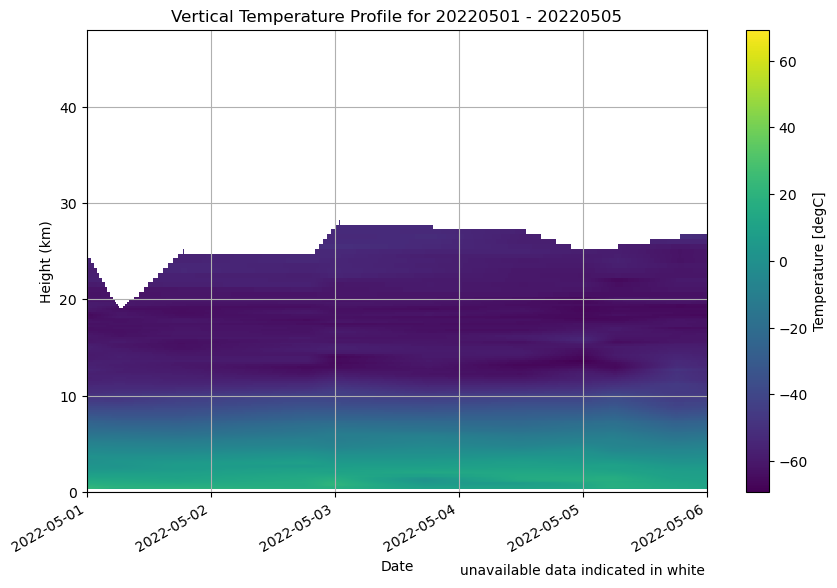

In [6]:
# Select the temperature data for the specified dates (20220501 - 20220505)
temp_data_filtered = sonde_ds['temp'].sel(time=slice('2022-05-01', '2022-05-05'))

# Create the plot using xarray's plot method
ax = temp_data_filtered.plot(x='time', y='height', cmap='viridis',ylim=[0,48.02], figsize=(10, 6))

# Add the title, labels, and grid
plt.title('Vertical Temperature Profile for 20220501 - 20220505')
plt.xlabel('Date')
plt.ylabel('Height (km)')
plt.grid(True)

# Add the note at the bottom outside of the plot
plt.annotate('unavailable data indicated in white', (0.8, -0.18), xycoords='axes fraction', fontsize=10,  ha='center')

plt.show()

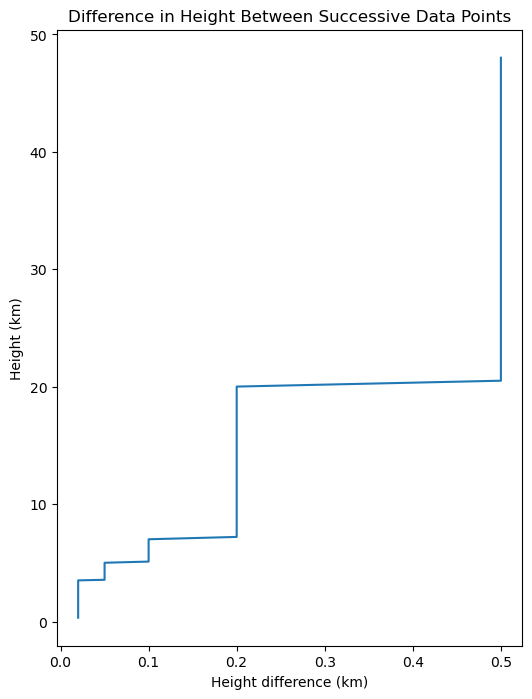

In [7]:
# Calculate the difference in height between each successive pair of data points
height_diff = sonde_ds['height'].diff('height')

# Create the plot
height_diff.plot(y='height', figsize=(6, 8))
plt.title('Difference in Height Between Successive Data Points')
plt.ylabel('Height (km)')
plt.xlabel('Height difference (km)')
plt.show()
# change bin size from 5km to 100m -> add to methodlogy -> above stay 200m 

# Pre-processing task 1 Sonde data
## Cut off at 5000m, use 100m bin size. Start from 300m

In [14]:
# Define the cutoff and bin sizes
cutoff_km = 5  # in kilometers (equivalent to 5000m)
bin_size_km = 0.1  # in kilometers (equivalent to 100m)

# Filter the data for heights within the specified range
filtered_dataset_km = sonde_ds.sel(height=slice(0.3, cutoff_km))  # Start from 0.3 km and go up to 5 km

# Calculate bin edges for the bin size
bin_edges_km = np.arange(0.3, cutoff_km + bin_size_km, bin_size_km)  # Start from 0.3 km and go up to 5 km

# Create a new dataset with binned data
binned_dataset_km = filtered_dataset_km.groupby_bins('height', bin_edges_km, labels=bin_edges_km[1:]).mean()

# Display the binned dataset
binned_dataset_km


<xarray.Dataset>
Dimensions:      (height_bins: 47, time: 527040)
Coordinates:
  * time         (time) datetime64[ns] 2022-04-01T00:00:30 ... 2023-04-01T23:...
  * height_bins  (height_bins) float64 0.4 0.5 0.6 0.7 0.8 ... 4.7 4.8 4.9 5.0
Data variables:
    bar_pres     (height_bins, time) float32 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    rh           (height_bins, time) float32 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    temp         (height_bins, time) float32 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    wdir         (height_bins, time) float32 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    wspd         (height_bins, time) float32 dask.array<chunksize=(1, 1440), meta=np.ndarray>
Attributes: (12/14)
    command_line:          idl -R -n interpolatedsonde -s sgp -f C1 -b 202204...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     sgpgriddedsondeC1.c0 : 3.2 : 20220330.000030-20220...
    site_id:               sgp
    ...                    ...
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               Fri Jul  7 13:09:19 2023: ncks -v temp,bar_pres,ws...
    NCO:                   netCDF Operators version 4.7.5 (Homepage = http://...

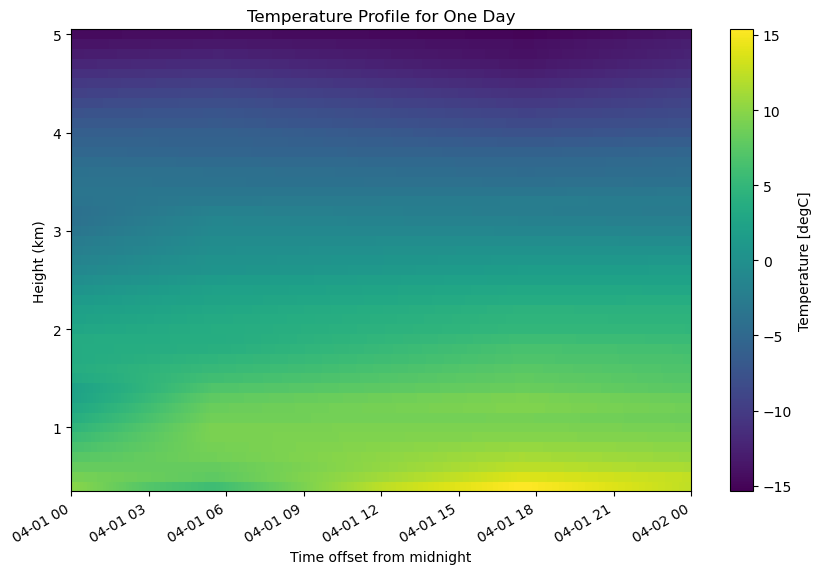

In [16]:
# Select one day of temperature data
temp_data = binned_dataset_km['temp'].isel(time=slice(0, 1440))

# Create the plot using xarray's plot method
temp_data.plot(x='time', y='height_bins', cmap='viridis', figsize=(10, 6))

plt.title('Temperature Profile for One Day')
plt.ylabel('Height (km)')
plt.show()

# Preprocessing task 2: Sonde data
## Resample to hourly

In [18]:
# Resample the dataset to hourly intervals
hourly_dataset_km = binned_dataset_km.resample(time='1H').mean()

# Display the hourly dataset
hourly_dataset_km

<xarray.Dataset>
Dimensions:      (time: 8784, height_bins: 47)
Coordinates:
  * height_bins  (height_bins) float64 0.4 0.5 0.6 0.7 0.8 ... 4.7 4.8 4.9 5.0
  * time         (time) datetime64[ns] 2022-04-01 ... 2023-04-01T23:00:00
Data variables:
    bar_pres     (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rh           (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    temp         (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wdir         (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wspd         (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/14)
    command_line:          idl -R -n interpolatedsonde -s sgp -f C1 -b 202204...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     sgpgriddedsondeC1.c0 : 3.2 : 20220330.000030-20220...
    site_id:               sgp
    ...                    ...
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               Fri Jul  7 13:09:19 2023: ncks -v temp,bar_pres,ws...
    NCO:                   netCDF Operators version 4.7.5 (Homepage = http://...

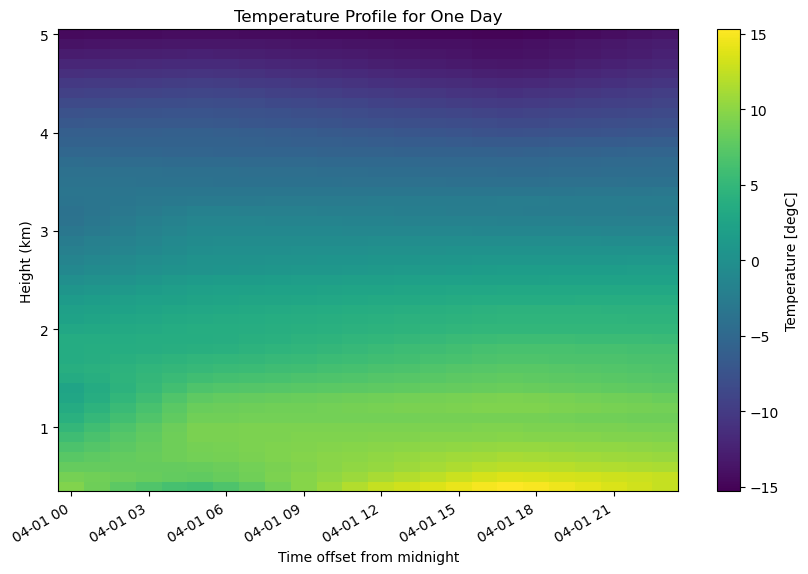

In [22]:
# Select one day of temperature data
temp_data = hourly_dataset_km['temp'].isel(time=slice(0, 24))

# Create the plot using xarray's plot method
temp_data.plot(x='time', y='height_bins', cmap='viridis', figsize=(10, 6))

plt.title('Temperature Profile for One Day')
plt.ylabel('Height (km)')
plt.show()

# Rain Gauge Data
- The 'tbrg_precip_total' variable represents the total precipitation recorded by the rain gauge, while the 'tbrg_precip_total_corr' variable represents the total precipitation corrected for losses due to wind, wetting, and evaporation.
- The difference between 'tbrg_precip_total_corr' and 'tbrg_precip_total' is consistently zero for all data points in this dataset. 

The 'qc_tbrg_precip_total' variable contains only one unique quality control flag: 0. 

In the context of the dataset, a flag of 0 usually indicates that the data point has passed all quality control checks and is considered good.

This means that all data points in 'tbrg_precip_total' are considered good according to the quality control checks, demonstrated from the graph below all points are coloured 0.

In [20]:
gauge_ds

<xarray.Dataset>
Dimensions:                  (time: 516621, bound: 2)
Coordinates:
  * time                     (time) datetime64[ns] 2022-04-01T00:01:00 ... 20...
Dimensions without coordinates: bound
Data variables: (12/32)
    base_time                (time) datetime64[ns] 2022-04-01 ... 2023-04-01
    time_offset              (time) datetime64[ns] dask.array<chunksize=(1416,), meta=np.ndarray>
    time_bounds              (time, bound) datetime64[ns] dask.array<chunksize=(1416, 2), meta=np.ndarray>
    temp_mean                (time) float32 dask.array<chunksize=(1416,), meta=np.ndarray>
    qc_temp_mean             (time) int32 dask.array<chunksize=(1416,), meta=np.ndarray>
    temp_std                 (time) float32 dask.array<chunksize=(1416,), meta=np.ndarray>
    ...                       ...
    qc_logger_volt           (time) int32 dask.array<chunksize=(1416,), meta=np.ndarray>
    logger_temp              (time) float32 dask.array<chunksize=(1416,), meta=np.ndarray>
    qc_logger_temp           (time) int32 dask.array<chunksize=(1416,), meta=np.ndarray>
    lat                      (time) float32 36.67 36.67 36.67 ... 36.67 36.67
    lon                      (time) float32 -97.62 -97.62 ... -97.62 -97.62
    alt                      (time) float32 311.5 311.5 311.5 ... 311.5 311.5
Attributes: (12/22)
    command_line:          precipmet_ingest -s sgp -f I10
    Conventions:           ARM-1.2
    process_version:       ingest-precipmet-1.1-0.el7
    dod_version:           precipmet-b1-1.1
    input_source:          /data/collection/sgp/sgpprecipmetI10.00/precipmet....
    site_id:               sgp
    ...                    ...
    qc_bit_3_description:  Value is greater than the valid_max.
    qc_bit_3_assessment:   Bad
    qc_bit_4_description:  Difference between current and previous values exc...
    qc_bit_4_assessment:   Indeterminate
    doi:                   10.5439/1353192
    history:               created by user dsmgr on machine flint at 2022-04-...

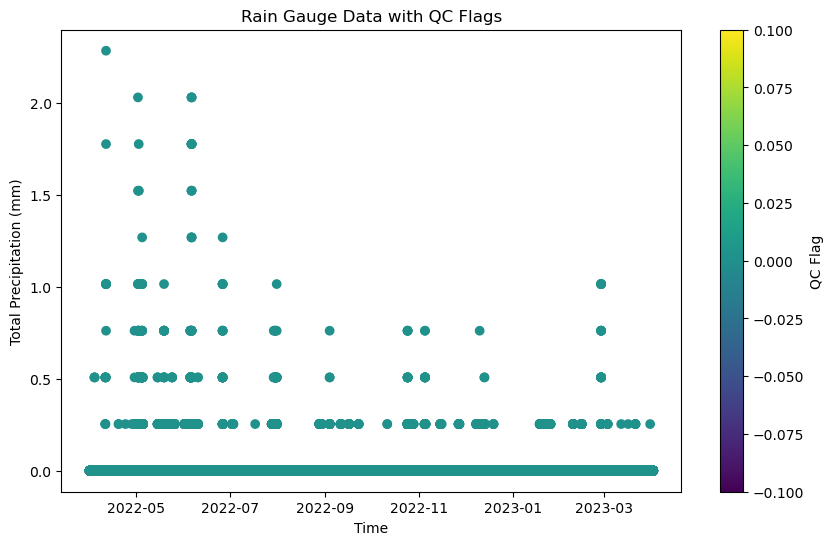

In [21]:
# Create a plot of the 'tbrg_precip_total' variable, with the color indicating the 'qc_tbrg_precip_total' variable
plt.figure(figsize=(10, 6))
plt.scatter(gauge_ds['time'].values, gauge_ds['tbrg_precip_total'].values, c=gauge_ds['qc_tbrg_precip_total'].values)
plt.colorbar(label='QC Flag')
plt.xlabel('Time')
plt.ylabel('Total Precipitation (mm)')
plt.title('Rain Gauge Data with QC Flags')
plt.show()

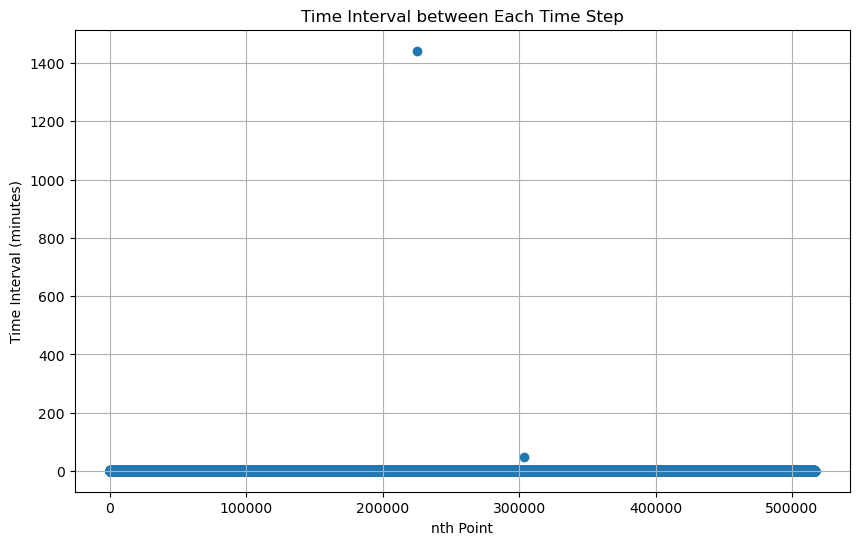

In [23]:
# Calculate the time differences in minutes
time_diffs_minutes = np.diff(gauge_ds['time'].values).astype('timedelta64[m]').astype(int)

# Identify the indices where the time difference is 2 minutes
indices_2_minutes = np.where(time_diffs_minutes == 2)[0]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(time_diffs_minutes)), time_diffs_minutes, marker='o')
plt.xlabel('nth Point')
plt.ylabel('Time Interval (minutes)')  # Corrected the label to 'minutes'
plt.title('Time Interval between Each Time Step')
plt.grid(True)
plt.show()


In [24]:
# Identify the indices where the time difference is greater than 10 minutes
indices_greater_than_10 = np.where(time_diffs_minutes > 10)[0]

# Find the corresponding time stamps for these indices
time_stamps_greater_than_10 = gauge_ds['time'].values[indices_greater_than_10]
time_stamps_greater_than_10_next = gauge_ds['time'].values[indices_greater_than_10 + 1]

# Convert to human-readable date-time format
formatted_time_stamps_start = [pd.Timestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in time_stamps_greater_than_10]
formatted_time_stamps_end = [pd.Timestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in time_stamps_greater_than_10_next]

# Print the date and time
for i, (start, end) in enumerate(zip(formatted_time_stamps_start, formatted_time_stamps_end)):
    print(f"Missing interval {i+1}: Starts at {start}, Ends at {end}")


Missing interval 1: Starts at 2022-09-06 23:59:00, Ends at 2022-09-08 00:01:00
Missing interval 2: Starts at 2022-11-02 14:59:00, Ends at 2022-11-02 15:47:00


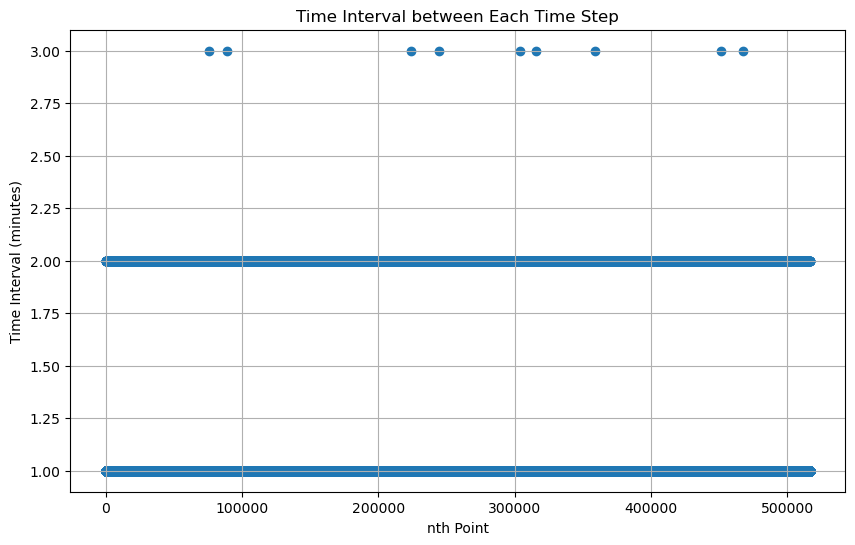

In [25]:
# Calculate the time differences in minutes
time_diffs_minutes = np.diff(gauge_ds['time'].values).astype('timedelta64[m]').astype(int)

# Remove time_diffs_minutes that are larger than 10
time_diffs_minutes = time_diffs_minutes[time_diffs_minutes <= 10]

# Identify the indices where the time difference is 2 minutes
indices_2_minutes = np.where(time_diffs_minutes == 2)[0]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(time_diffs_minutes)), time_diffs_minutes, marker='o')
plt.xlabel('nth Point')
plt.ylabel('Time Interval (minutes)')  # Corrected the label to 'minutes'
plt.title('Time Interval between Each Time Step')
plt.grid(True)
plt.show()


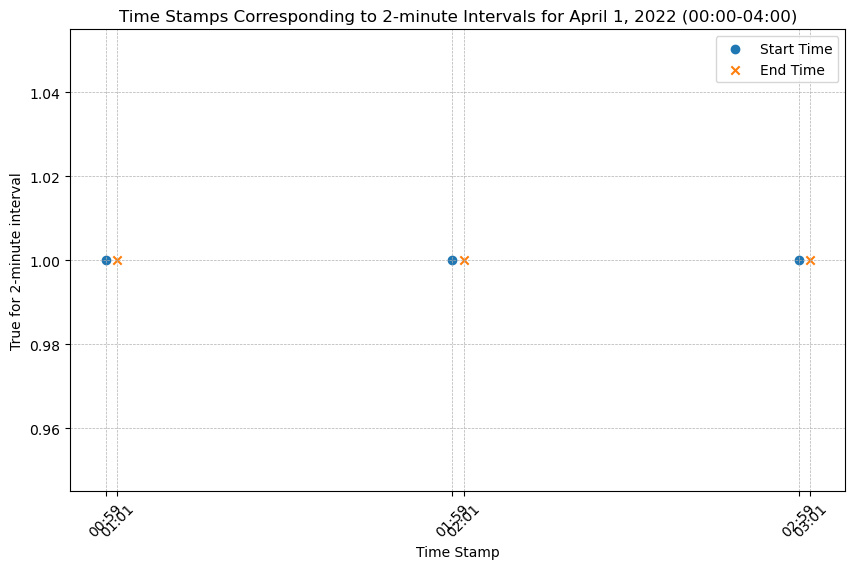

In [26]:
# Filter data for a specific day (e.g., April 1, 2022)
gauge_ds_day = gauge_ds.sel(time=slice("2022-04-01", "2022-04-01"))

# Further filter to a 5-hour window (e.g., from 00:00 to 05:00)
gauge_ds_5hr = gauge_ds_day.sel(time=slice("2022-04-01T00:00:00", "2022-04-01T04:00:00"))

# Calculate the time differences in minutes
time_diffs_minutes = np.diff(gauge_ds_5hr['time'].values).astype('timedelta64[m]').astype(int)

# Remove time_diffs_minutes that are larger than 10
time_diffs_minutes = time_diffs_minutes[time_diffs_minutes <= 10]

# Identify the indices where the time difference is 2 minutes
indices_2_minutes = np.where(time_diffs_minutes == 2)[0]

# Find the corresponding time stamps
time_stamps_2_minutes = gauge_ds_5hr['time'].values[indices_2_minutes]
time_stamps_2_minutes_next = gauge_ds_5hr['time'].values[indices_2_minutes + 1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(time_stamps_2_minutes, [True]*len(time_stamps_2_minutes), marker='o', label='Start Time')
plt.scatter(time_stamps_2_minutes_next, [True]*len(time_stamps_2_minutes_next), marker='x', label='End Time')

# Custom x-axis labels for existing data points
unique_time_stamps = np.unique(np.concatenate([time_stamps_2_minutes, time_stamps_2_minutes_next]))
formatted_time_stamps = [pd.Timestamp(ts).strftime('%H:%M') for ts in unique_time_stamps]

plt.xticks(unique_time_stamps, formatted_time_stamps, rotation=45)

plt.xlabel('Time Stamp')
plt.ylabel('True for 2-minute interval')
plt.title('Time Stamps Corresponding to 2-minute Intervals for April 1, 2022 (00:00-04:00)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


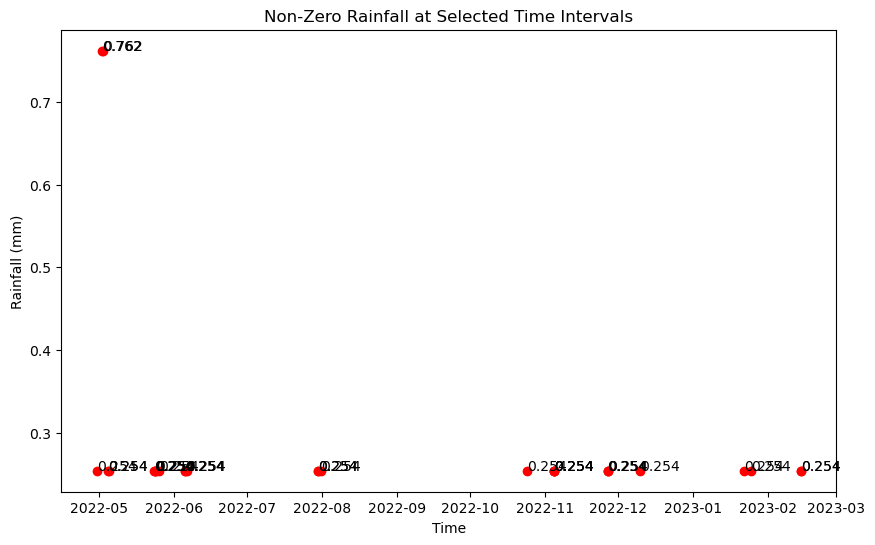

In [29]:
# Calculate the time differences in minutes
time_diffs_minutes = np.diff(gauge_ds['time'].values).astype('timedelta64[m]').astype(int)

# Identify the indices where time differences are not 1 minute and less than 10 minutes
indices = np.where((time_diffs_minutes != 1) & (time_diffs_minutes < 10))[0]

# Get the corresponding times and rainfall values
selected_times = gauge_ds['time'].values[indices]
selected_rainfall = gauge_ds['tbrg_precip_total'].values[indices]


# Filter out zero rainfall values
non_zero_indices = np.where(selected_rainfall != 0)[0]
selected_times_non_zero = selected_times[non_zero_indices]
selected_rainfall_non_zero = selected_rainfall[non_zero_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(selected_times_non_zero, selected_rainfall_non_zero, color='red')
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.title('Non-Zero Rainfall at Selected Time Intervals')
for i, txt in enumerate(selected_rainfall_non_zero):
    plt.annotate(txt, (selected_times_non_zero[i], selected_rainfall_non_zero[i]))
plt.show()

In [30]:
np.size(selected_rainfall)

8921

In [31]:
np.size(selected_rainfall_non_zero)

33

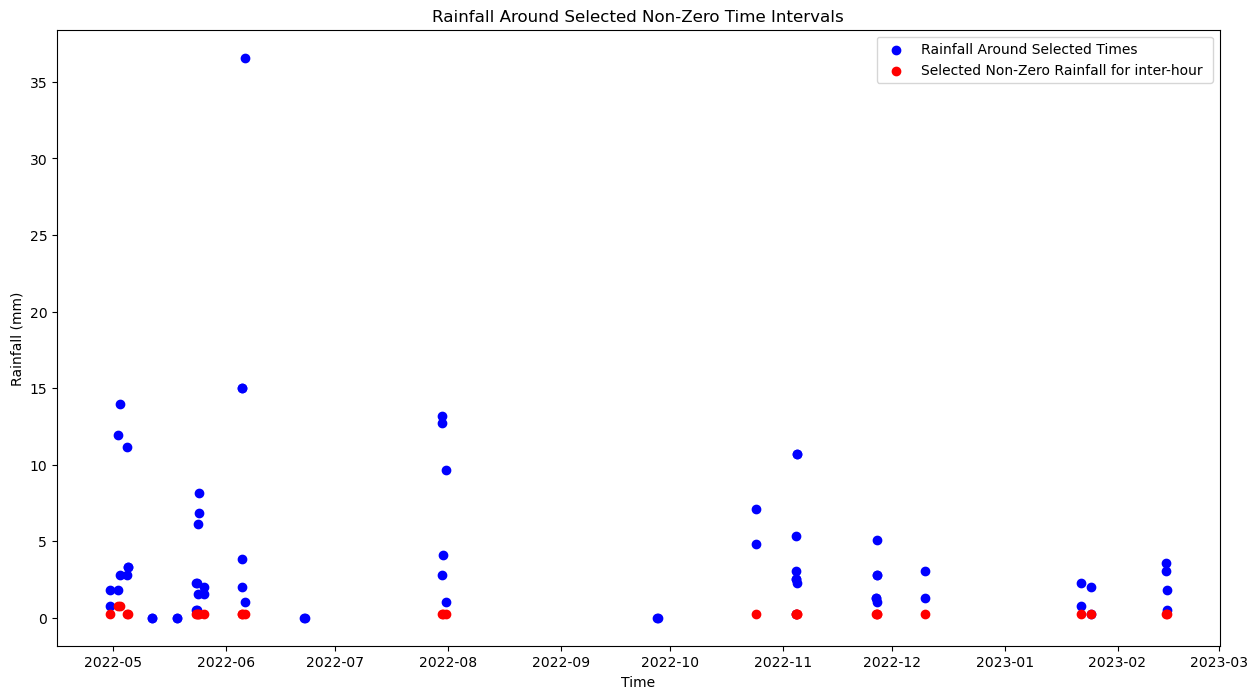

In [32]:
# Convert selected_times_non_zero to a pandas datetime index
selected_times_dt = pd.to_datetime(selected_times_non_zero)

# Create a DataFrame for hourly rain
hourly_rain_df = pd.DataFrame(hourly_rain.values, index=pd.to_datetime(hourly_rain['time'].values), columns=['Rainfall'])

# Initialize lists to store the rainfall values and corresponding times
rainfall_around_selected = []
times_around_selected = []

# Loop through each selected time
for time in selected_times_dt:
    # Define the time range for one hour before and after the selected time
    start_time = time - pd.Timedelta(hours=1)
    end_time = time + pd.Timedelta(hours=1)
    
    # Extract the rainfall values within this time range
    rainfall_values = hourly_rain_df.loc[start_time:end_time]['Rainfall'].values
    time_values = hourly_rain_df.loc[start_time:end_time].index.values
    
    # Append these to the lists
    rainfall_around_selected.extend(rainfall_values)
    times_around_selected.extend(time_values)

# Plotting
plt.figure(figsize=(15, 8))
plt.scatter(times_around_selected, rainfall_around_selected, color='blue', label='Rainfall Around Selected Times')
plt.scatter(selected_times_non_zero, selected_rainfall_non_zero, color='red', label='Selected Non-Zero Rainfall for inter-hour ')
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Around Selected Non-Zero Time Intervals')
plt.legend()
plt.show()

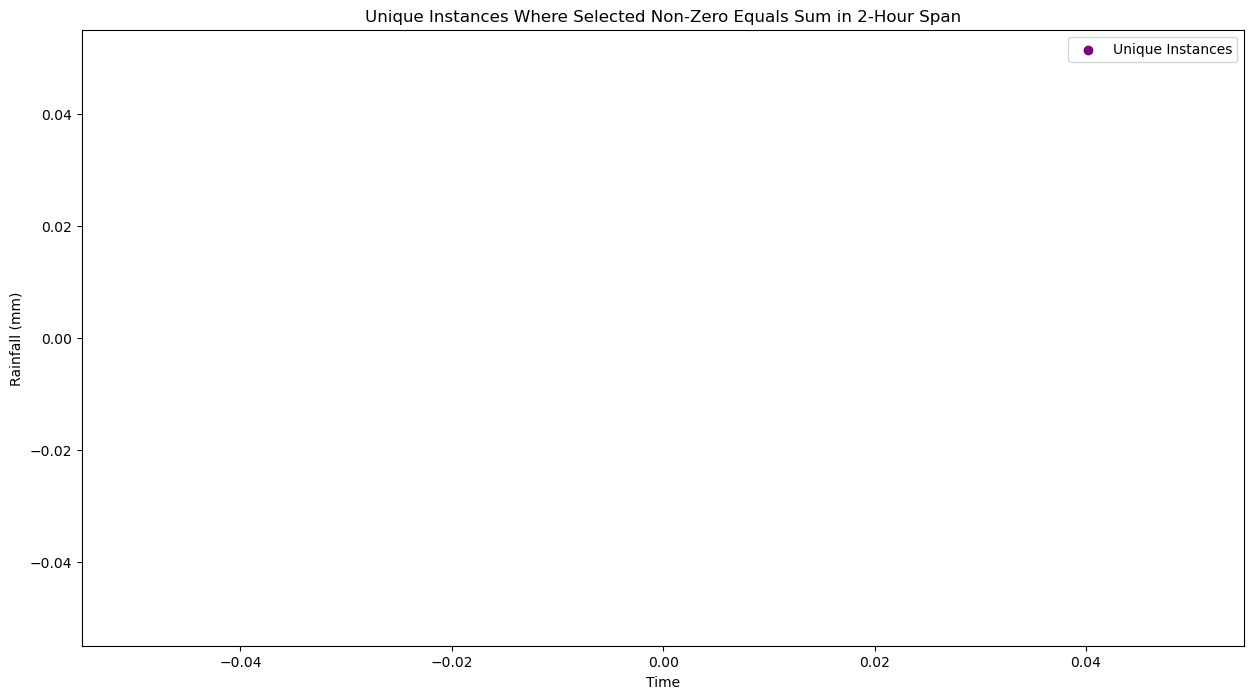

In [33]:
# Initialize lists to store the unique instances
unique_times = []
unique_rainfall = []
# Loop through each selected time
for idx, time in enumerate(selected_times_dt):
    # Define the time range for one hour before and after the selected time
    start_time = time - pd.Timedelta(hours=1)
    end_time = time + pd.Timedelta(hours=1)
    
    # Extract the rainfall values within this time range
    rainfall_values = hourly_rain_df.loc[start_time:end_time]['Rainfall'].values
    
    # Check if the selected non-zero point is the only non-zero point in the 2-hour span
    # and its value equals the sum of all rainfall in that span
    if np.sum(rainfall_values) == selected_rainfall_non_zero[idx]:
        unique_times.append(time)
        unique_rainfall.append(selected_rainfall_non_zero[idx])

# Plotting
plt.figure(figsize=(15, 8))

# Plot the unique instances
plt.scatter(unique_times, unique_rainfall, color='purple', label='Unique Instances')
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.title('Unique Instances Where Selected Non-Zero Equals Sum in 2-Hour Span')
plt.legend()
plt.show()

# Resample to hourly

In [27]:
# Correct for the time interval between data points
time_interval = gauge_ds['time'].diff('time')
# Resample the corrected time interval to hourly intervals, summing the values within each hour
hourly_time_interval = time_interval.resample(time='1H').sum()

# Convert the hourly time interval from a timedelta to a number of minutes
num_data_points_hourly = hourly_time_interval / np.timedelta64(1, 'm')

# Divide by 60 to normalize the number of data points
num_data_points_normalized_hourly = num_data_points_hourly / 60

# Resample the 'tbrg_precip_total' variable to hourly intervals, summing the values within each hour
hourly_rain = gauge_ds['tbrg_precip_total'].resample(time='1H').sum()

# Add the 'num_data_points_normalized_hourly' variable to the 'hourly_rain' DataArray as a new coordinate
hourly_rain = hourly_rain.assign_coords(num_data_points_normalized_hourly=num_data_points_normalized_hourly)

# Display the updated 'hourly_rain' DataArray
hourly_rain

<xarray.DataArray 'tbrg_precip_total' (time: 8784)>
dask.array<where, shape=(8784,), dtype=float32, chunksize=(25,), chunktype=numpy.ndarray>
Coordinates:
  * time                               (time) datetime64[ns] 2022-04-01 ... 2...
    num_data_points_normalized_hourly  (time) float64 0.9667 1.0 1.0 ... 1.0 1.0
Attributes:
    long_name:            TBRG precipitation total
    units:                mm
    ancillary_variables:  qc_tbrg_precip_total
    valid_min:            0.0
    valid_max:            10.0
    cell_methods:         time: sum
    standard_name:        thickness_of_rainfall_amount

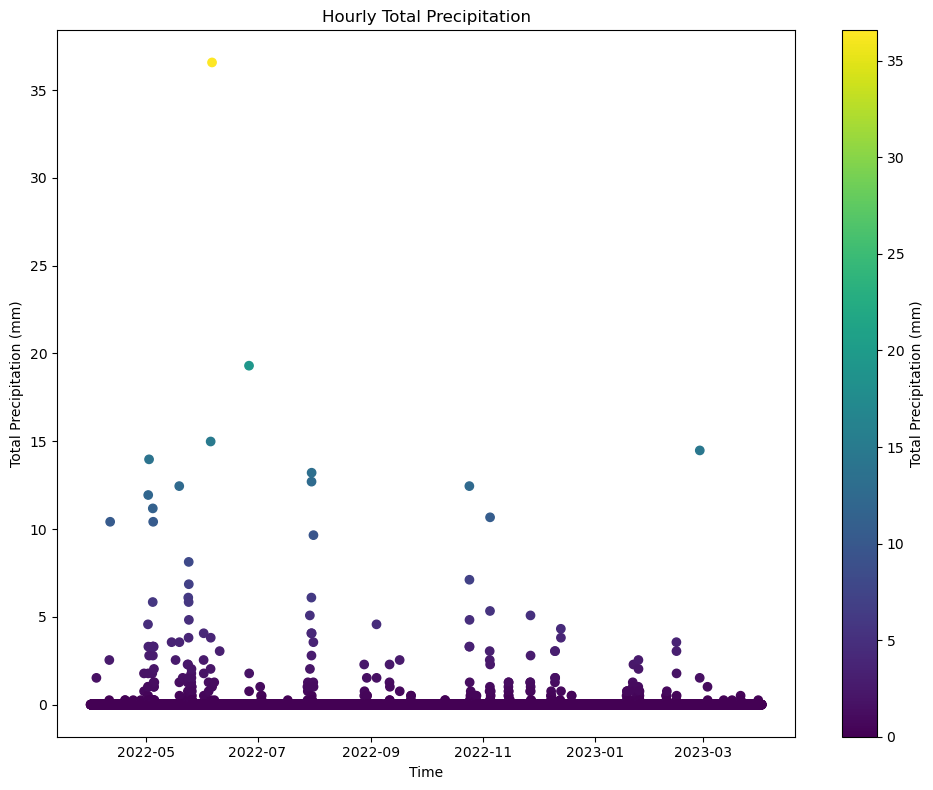

In [28]:
import matplotlib.cm as cm
# Create a figure with a single subplot for the hourly rain data
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot the hourly rain data as a scatter plot, color-coded by the amount of precipitation
sc = ax1.scatter(hourly_rain.time, hourly_rain, c=hourly_rain, cmap=cm.viridis)
plt.colorbar(sc, ax=ax1, label='Total Precipitation (mm)')

# Set labels and title
ax1.set_ylabel('Total Precipitation (mm)')
ax1.set_title('Hourly Total Precipitation')
ax1.set_xlabel('Time')

# Adjust the layout
plt.tight_layout()
plt.show()


In [34]:
# Show time is turned into on the :00 of each hour
hourly_rain['time'].values

array(['2022-04-01T00:00:00.000000000', '2022-04-01T01:00:00.000000000',
       '2022-04-01T02:00:00.000000000', ...,
       '2023-04-01T21:00:00.000000000', '2023-04-01T22:00:00.000000000',
       '2023-04-01T23:00:00.000000000'], dtype='datetime64[ns]')

# Radar Data

In [35]:
# Set the path to the directory containing the files
path_r = '/Users/Anakinchan/Desktop/masters/Sem 3 - Diss/Radar_data_1/'

# Define the naming convention for the files
file_pattern_r = 'st4_conus.*.01h.nc'

# Get a list of file paths matching the pattern
file_paths = sorted([os.path.join(path_r, file_name) for file_name in os.listdir(path_r) if file_name.startswith('st4_conus') and file_name.endswith('.01h.nc')])

# Open the multi-file dataset
#radar_ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='time')

# Select the grid point of interest
#radar_ds_selected = radar_ds.isel(lat=16, lon=24)

Loop through the files, use netCDF4 package to open, extract time and rain rate at location of rain gauge -> save to a dataset then convert to a xarray dataset with time reference.

## Finding the closest grid point to a given latitude and longitude using the haversine formula:

Given a point \($P$\) with latitude \($\phi_P$\) and longitude \($\lambda_P$\), and a grid of points \($G$\) with latitudes \($\phi_G$\) and longitudes \($\lambda_G$\), the haversine formula provides the great-circle distance between \($P$\) and each point in \($G$\). This distance \($d$\) is given by:

$$
a = \sin^2\left(\frac{\phi_G - \phi_P}{2}\right) + \cos(\phi_P) \cdot \cos(\phi_G) \cdot \sin^2\left(\frac{\lambda_G - \lambda_P}{2}\right)
$$

$$
d = 2 \cdot \arcsin\left(\sqrt{a}\right)
$$

The point in \($G$\) with the smallest distance \($d$\) to \($P$\) is the closest grid point.

In [36]:
# Define the gauge location
gauge_lat = 36.665570
gauge_lon = -97.628475

# Initialize empty lists to store the data and time from each file
all_data = []
all_time = []

# Initialize an empty list to store the file paths of files without the 'APCP_01' variable
missing_files = []

# Loop over each file path
for file_path in file_paths:
    # Open the netCDF file
    radar = nc.Dataset(file_path)

    # Get the latitude and longitude variables
    lat = radar['lat'][:]
    lon = radar['lon'][:]

    # Convert lat, lon, and gauge location to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    gauge_lat_rad = np.radians(gauge_lat)
    gauge_lon_rad = np.radians(gauge_lon)

    # Compute the differences in coordinates
    dlat = lat_rad - gauge_lat_rad
    dlon = lon_rad - gauge_lon_rad

    # Use the haversine formula to compute the great circle distance
    a = np.sin(dlat / 2)**2 + np.cos(gauge_lat_rad) * np.cos(lat_rad) * np.sin(dlon / 2)**2
    a = np.maximum(a, 0)  # ensure all values are non-negative
    dist = 2 * np.arcsin(np.sqrt(a))

    # Find the 2D index of the minimum distance
    nearest_idx = np.unravel_index(np.argmin(dist), dist.shape)

    # Try to extract the data for the nearest grid box
    try:
        nearest_grid_data = radar['APCP_01'][nearest_idx]
        if isinstance(nearest_grid_data, np.ma.MaskedArray):
            nearest_grid_data = nearest_grid_data.filled(np.nan)  # replace masked values with NaN
    except IndexError:
        # If the 'APCP_01' variable doesn't exist, store the file path and continue to the next file
        missing_files.append(file_path)
        continue

    # Extract the time from the valid_time attribute and parse it into a datetime object
    time_str = radar['APCP_01'].valid_time
    time_format = "%Y%m%d_%H%M%S"  # Define the time format
    time = datetime.strptime(time_str, time_format)  # Parse the time string into a datetime object

    # Append the data and time to the lists
    all_data.append(float(nearest_grid_data))
    all_time.append(time)

    # Close the dataset 
    radar.close()

# Convert the lists to a pandas DataFrame
df = pd.DataFrame({
    'time': all_time,
    'radar_rain': all_data
})

# Set 'time' as the index (this will make 'time' a coordinate when converted to a Dataset)
df.set_index('time', inplace=True)

# Convert the DataFrame to an xarray Dataset
radar_ds = xr.Dataset.from_dataframe(df)

# Print the file paths of files without the 'APCP_01' variable
print("Files without the 'APCP_01' variable:", missing_files)


Files without the 'APCP_01' variable: []


# Investigate missing data

In [37]:
# Convert the time coordinate to a pandas DatetimeIndex
time_index = pd.DatetimeIndex(radar_ds['time'].values)

# Create a new DatetimeIndex that represents the full range of dates and hours
full_time_index = pd.date_range(start='2022-04-01T00:00:00', end=time_index.max(), freq='H')

# Find the missing hours by comparing the full time index with the actual time index
missing_hours = full_time_index.difference(time_index)

# Print the missing hours
missing_hours


DatetimeIndex(['2022-04-01 00:00:00', '2022-04-01 01:00:00'], dtype='datetime64[ns]', freq=None)

In [38]:
np.size(missing_hours)

2

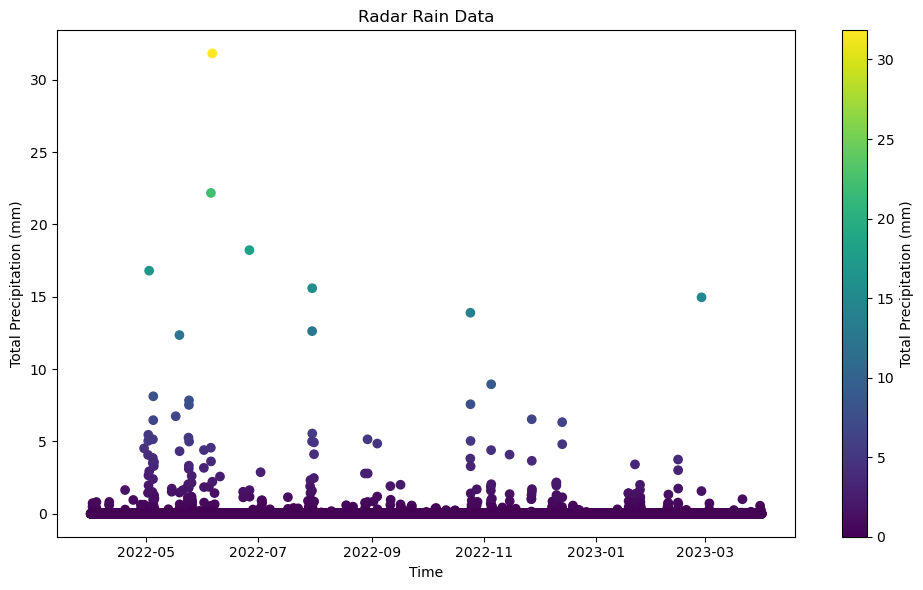

In [40]:
# Create a figure with a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the radar rain data as a scatter plot, color-coded by the amount of precipitation
sc = ax1.scatter(radar_ds['time'].values, radar_ds['radar_rain'].values, c=radar_ds['radar_rain'].values, cmap=cm.viridis)
plt.colorbar(sc, ax=ax1, label='Total Precipitation (mm)')

# Set labels and title
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Precipitation (mm)')
ax1.set_title('Radar Rain Data')

# Adjust the layout
plt.tight_layout()
plt.show()


## Now combine the dataset 
- check if there are any missing dates or files.

In [41]:
# Align the datasets on the 'time' coordinate
aligned_datasets = xr.align(hourly_dataset_km, hourly_rain, radar_ds, join='outer')

# Combine the aligned datasets into one dataset
combined_ds = xr.merge(aligned_datasets)

combined_ds

<xarray.Dataset>
Dimensions:                            (height_bins: 47, time: 8784)
Coordinates:
  * height_bins                        (height_bins) float64 0.4 0.5 ... 4.9 5.0
  * time                               (time) datetime64[ns] 2022-04-01 ... 2...
    num_data_points_normalized_hourly  (time) float64 0.9667 1.0 1.0 ... 1.0 1.0
Data variables:
    bar_pres                           (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rh                                 (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    temp                               (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wdir                               (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wspd                               (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    tbrg_precip_total                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    radar_rain                         (time) float64 nan nan 0.0 ... nan nan
Attributes: (12/14)
    command_line:          idl -R -n interpolatedsonde -s sgp -f C1 -b 202204...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     sgpgriddedsondeC1.c0 : 3.2 : 20220330.000030-20220...
    site_id:               sgp
    ...                    ...
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               Fri Jul  7 13:09:19 2023: ncks -v temp,bar_pres,ws...
    NCO:                   netCDF Operators version 4.7.5 (Homepage = http://...

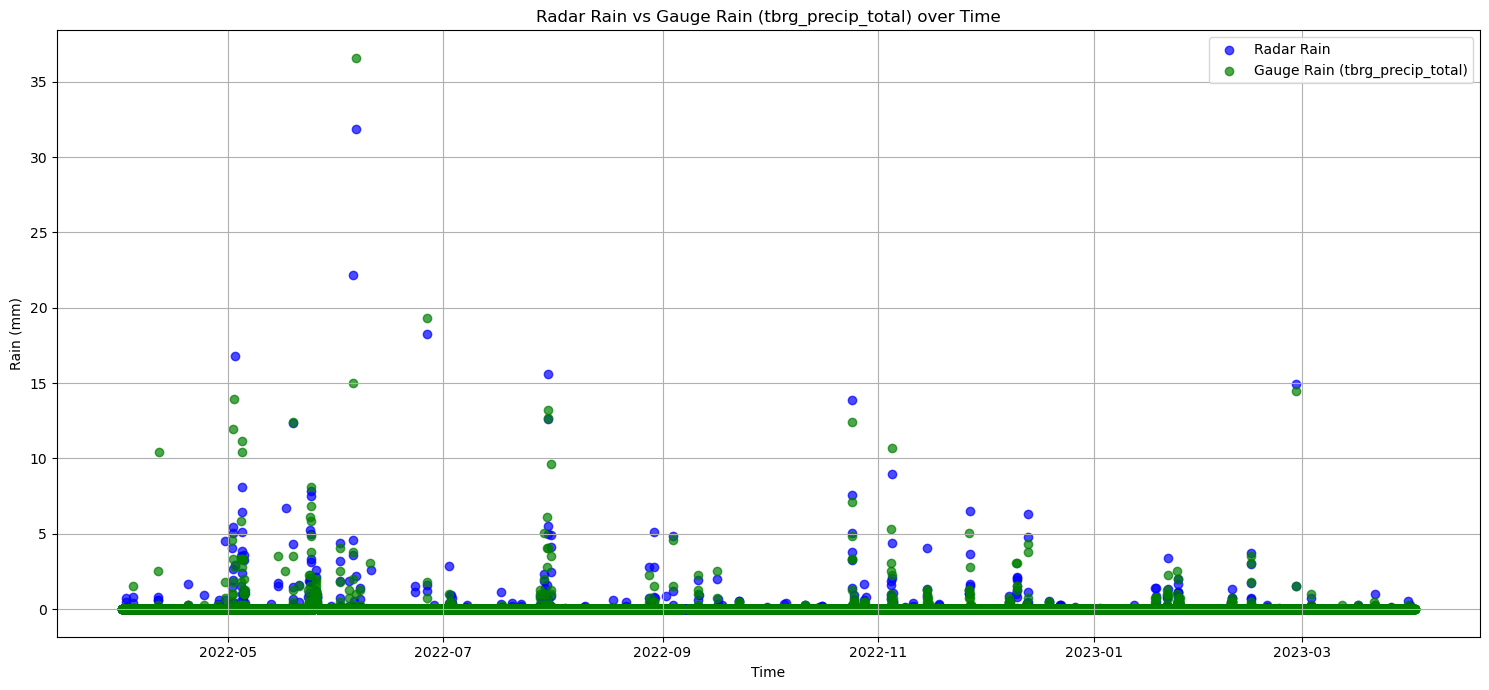

In [89]:
# Extracting radar rain, gauge rain, and time from the dataset
radar_rain = combined_ds["radar_rain"].values
gauge_rain = combined_ds["tbrg_precip_total"].values
time_values = combined_ds["time"].values

# Plotting radar rain and gauge rain on the same plot with time on the x-axis
plt.figure(figsize=(15, 7))
plt.scatter(time_values, radar_rain, label="Radar Rain", color='blue', alpha=0.7)
plt.scatter(time_values, gauge_rain, label="Gauge Rain (tbrg_precip_total)", color='green', alpha=0.7)
plt.title("Radar Rain vs Gauge Rain (tbrg_precip_total) over Time")
plt.xlabel("Time")
plt.ylabel("Rain (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("gauge_radar_rain.png")

plt.show()

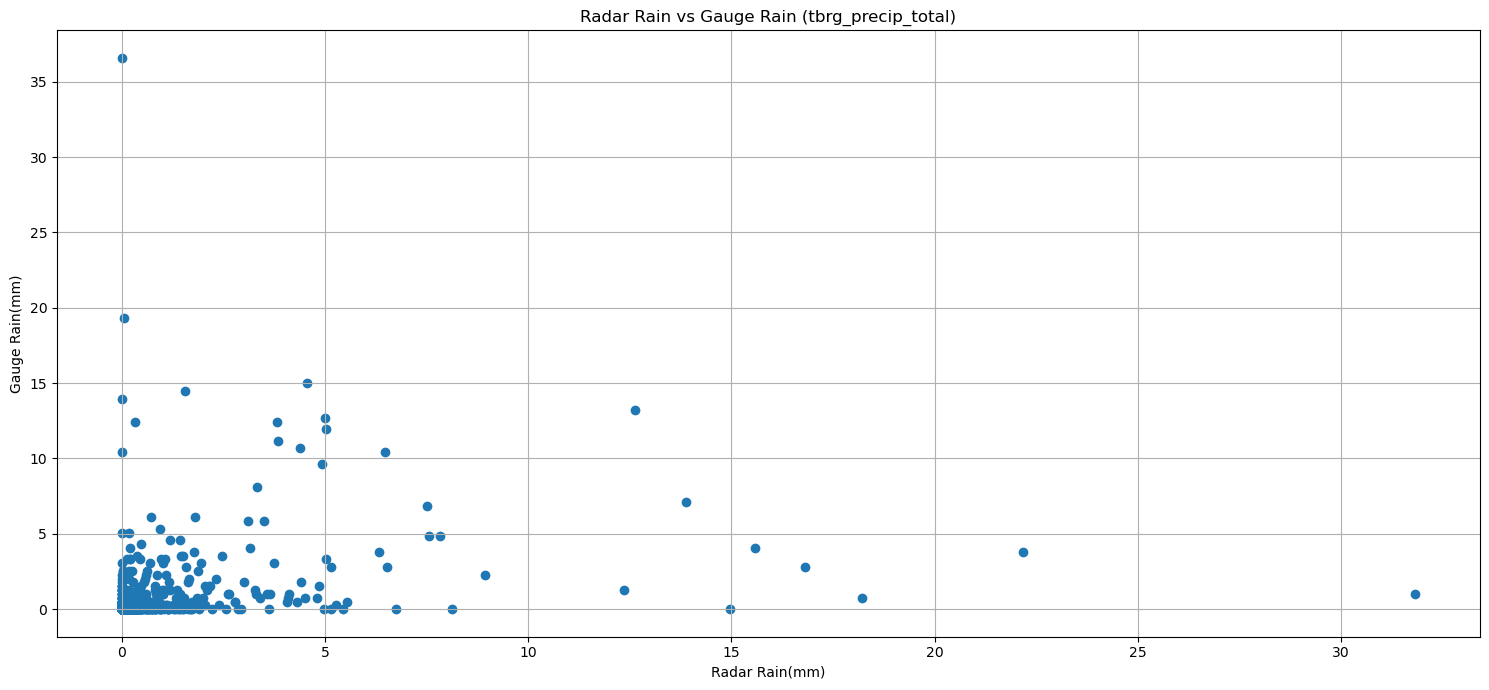

In [43]:
# Plotting radar rain and gauge rain on the same plot with time on the x-axis
plt.figure(figsize=(15, 7))
plt.scatter(radar_rain,gauge_rain, label="Radar Rain")
plt.title("Radar Rain vs Gauge Rain (tbrg_precip_total)")
plt.xlabel("Radar Rain(mm)")
plt.ylabel("Gauge Rain(mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Check each variable for missing values again
missing_values = combined_ds.isnull().sum(dim=['time', 'height_bins'])

# Display the result
missing_values


<xarray.Dataset>
Dimensions:            ()
Data variables:
    bar_pres           int64 dask.array<chunksize=(), meta=np.ndarray>
    rh                 int64 dask.array<chunksize=(), meta=np.ndarray>
    temp               int64 dask.array<chunksize=(), meta=np.ndarray>
    wdir               int64 dask.array<chunksize=(), meta=np.ndarray>
    wspd               int64 dask.array<chunksize=(), meta=np.ndarray>
    tbrg_precip_total  int64 dask.array<chunksize=(), meta=np.ndarray>
    radar_rain         int64 26

# one hot encoding
In the context of rainfall detection, we are interested in differentiating between two fundamental states: rain and no rain. Rainfall measurements obtained through both radar and gauge instruments present us with two distinct perspectives. Our aim is to investigate discrepancies between these measurements and classify them into distinct categories.

For this study, we denote the radar rainfall at a given time point as \( R \) and the gauge rainfall as \( G \). We set the threshold for significant rainfall as \( T \), which in this case is set to 0 mm/hr, indicating any amount of rainfall is considered as a rainy event.

We create new boolean variables, `radar_bool` and `gauge_bool`, which are indicative of whether the radar and gauge measurements respectively exceed the threshold. These variables can be defined mathematically as follows:

$$
\text{{$radar\_bool$}} = 
\begin{cases} 
1, & \text{{if }} R > T \\
0, & \text{{otherwise}}
\end{cases}
$$

$$
\text{{$gauge\_bool$}} = 
\begin{cases} 
1, & \text{{if }} G > T \\
0, & \text{{otherwise}}
\end{cases}
$$

Subsequently, we classify each time point into one of four categories based on the combinations of `radar_bool` and `gauge_bool`. These categories are as follows:

- Class 1: Both radar and gauge report no rainfall (`radar_bool = 0`, `gauge_bool = 0`)
- Class 2: The radar indicates no rainfall while the gauge reports rainfall (`radar_bool = 0`, `gauge_bool = 1`)
- Class 3: The radar reports rainfall while the gauge indicates no rainfall (`radar_bool = 1`, `gauge_bool = 0`)
- Class 4: Both radar and gauge report rainfall (`radar_bool = 1`, `gauge_bool = 1`)

### Lastly, we convert these categories into a one-hot encoded format. 
For each class \(i\), we create a 4-element vector where the \(i\)-th element is 1, and the remaining elements are 0. For instance, Class 1 is represented as [1, 0, 0, 0], while Class 4 is represented as [0, 0, 0, 1]. These one-hot encoded vectors will serve as the target variable for our classification task.

By transforming the original rainfall measurements in this manner, we can effectively categorize discrepancies between radar and gauge measurements. This allows us to leverage machine learning techniques for our classification problem and provides a foundation for further investigation into these discrepancies.


In [46]:
# Define the rainfall threshold
threshold = 0

# Create boolean variables indicating whether the radar and gauge rain rates exceed the threshold
combined_ds['radar_bool'] = combined_ds['radar_rain'] > threshold
combined_ds['gauge_bool'] = combined_ds['tbrg_precip_total'] > threshold

# Define the classes based on the boolean variables
combined_ds['class'] = xr.full_like(combined_ds['radar_bool'], 1, dtype=int)  # Initialize all as class 1
combined_ds['class'] = combined_ds['class'].where(~((combined_ds['radar_bool'] == False) & (combined_ds['gauge_bool'] == True)), 2)  # Update to class 2 where necessary
combined_ds['class'] = combined_ds['class'].where(~((combined_ds['radar_bool'] == True) & (combined_ds['gauge_bool'] == False)), 3)  # Update to class 3 where necessary
combined_ds['class'] = combined_ds['class'].where(~((combined_ds['radar_bool'] == True) & (combined_ds['gauge_bool'] == True)), 4)  # Update to class 4 where necessary

# Create a coordinate for the classes
combined_ds = combined_ds.assign_coords(class_coord=('class', ['No Rain', 'Gauge Rain Only', 'Radar Rain Only', 'Both Radar and Gauge Rain']))

# Create a new variable for the one-hot encoded classes
combined_ds['class_one_hot'] = xr.DataArray(
    np.eye(4)[combined_ds['class']-1],  # Subtract 1 because Python uses 0-based indexing
    dims=('time', 'one_hot_dim'),
    coords={'time': combined_ds['time']}
)

# Drop the intermediate variables created
combined_ds = combined_ds.drop_vars(['radar_bool', 'gauge_bool', 'class'])

# Print the first 5 values of the new variable
combined_ds['class_one_hot'].isel(time=slice(0, 5))


<xarray.DataArray 'class_one_hot' (time: 5, one_hot_dim: 4)>
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])
Coordinates:
  * time                               (time) datetime64[ns] 2022-04-01 ... 2...
    num_data_points_normalized_hourly  (time) float64 0.9667 1.0 1.0 1.0 1.0
Dimensions without coordinates: one_hot_dim

In [47]:
# Calculate the proportion of time steps in each class
class_counts = combined_ds['class_one_hot'].sum(dim='time')  # Sum over the 'time' dimension
class_proportions = class_counts / len(combined_ds['time'])  # Divide by the total number of time steps

# Print the class proportions
class_proportions


<xarray.DataArray 'class_one_hot' (one_hot_dim: 4)>
array([0.9477459 , 0.00614754, 0.02140255, 0.02470401])
Dimensions without coordinates: one_hot_dim

# The proportion of data for each class is as follows:

- 'No Rain': 94.775% no. of observations: 8330
- 'Gauge Rain Only': 0.615% no. of observations: 57
- 'Radar Rain Only': 2.140% no. of observations: 183
- 'Both Radar and Gauge Rain': 2.470% no. of observations: 214

These proportions suggest that most of the time (94.775%), both the radar and the gauge did not detect any rain ('No Rain'). 

Discrepancies between the radar and gauge measurements exist in 2.755% of the time, where either the radar detected rain while the gauge did not ('Radar Rain Only'), or vice versa ('Gauge Rain Only').

In 2.470% of the time, both the radar and the gauge detected rain ('Both Radar and Gauge Rain').

# Data-Preprocessing

In [49]:
# Create a new dataset for modelling
ml_ds = combined_ds
ml_ds = ml_ds.drop_vars(['tbrg_precip_total','radar_rain','num_data_points_normalized_hourly'])

# print out the dataset
ml_ds

<xarray.Dataset>
Dimensions:        (height_bins: 47, time: 8784, class: 4, one_hot_dim: 4)
Coordinates:
  * height_bins    (height_bins) float64 0.4 0.5 0.6 0.7 0.8 ... 4.7 4.8 4.9 5.0
  * time           (time) datetime64[ns] 2022-04-01 ... 2023-04-01T23:00:00
    class_coord    (class) <U25 'No Rain' ... 'Both Radar and Gauge Rain'
Dimensions without coordinates: class, one_hot_dim
Data variables:
    bar_pres       (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rh             (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    temp           (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wdir           (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    wspd           (time, height_bins) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    class_one_hot  (time, one_hot_dim) float64 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/14)
    command_line:          idl -R -n interpolatedsonde -s sgp -f C1 -b 202204...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     sgpgriddedsondeC1.c0 : 3.2 : 20220330.000030-20220...
    site_id:               sgp
    ...                    ...
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               Fri Jul  7 13:09:19 2023: ncks -v temp,bar_pres,ws...
    NCO:                   netCDF Operators version 4.7.5 (Homepage = http://...

In [56]:
# Round the height_bins values to one decimal point
ml_ds['height_bins'] = np.around(ml_ds['height_bins'].values, 1)

In [57]:
# Convert the xarray.Dataset to a pandas.DataFrame
data_vars = ['bar_pres', 'rh', 'temp', 'wdir', 'wspd']
heights = ml_ds.height_bins.values

In [58]:
heights

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
       3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
       4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [59]:
# Initialize a dictionary to hold the dataframes for each variable
dfs = {}

# Iterate over the data variables and heights
for var in data_vars:
    for height in heights:
        # Select the data for the current variable and height
        data = ml_ds[var].sel(height_bins=height)
        # Convert the data to a pandas DataFrame and add it to the dictionary
        dfs[f'{var}_{height}'] = data.to_dataframe()

# Concatenate the dataframes along the columns axis
df = pd.concat(dfs, axis=1)

# Print the first few rows of the dataframe
df.head()

bar_pres_0.4            bar_pres_0.5             \
                     height_bins   bar_pres  height_bins   bar_pres   
time                                                                  
2022-04-01 00:00:00          0.4  97.109062          0.5  95.940025   
2022-04-01 01:00:00          0.4  97.140656          0.5  95.965744   
2022-04-01 02:00:00          0.4  97.172226          0.5  95.991470   
2022-04-01 03:00:00          0.4  97.199661          0.5  96.017174   
2022-04-01 04:00:00          0.4  97.221558          0.5  96.042900   

                    bar_pres_0.6            bar_pres_0.7             \
                     height_bins   bar_pres  height_bins   bar_pres   
time                                                                  
2022-04-01 00:00:00          0.6  94.785439          0.7  93.641487   
2022-04-01 01:00:00          0.6  94.810410          0.7  93.666702   
2022-04-01 02:00:00          0.6  94.835365          0.7  93.691910   
2022-04-01 03:00:00          0.6  94.860344          0.7  93.717094   
2022-04-01 04:00:00          0.6  94.885323          0.7  93.742317   

                    bar_pres_0.8             ...    wspd_4.6             \
                     height_bins   bar_pres  ... height_bins       wspd   
time                                         ...                          
2022-04-01 00:00:00          0.8  92.508881  ...         4.6  15.061069   
2022-04-01 01:00:00          0.8  92.535263  ...         4.6  14.434503   
2022-04-01 02:00:00          0.8  92.561630  ...         4.6  13.819322   
2022-04-01 03:00:00          0.8  92.588013  ...         4.6  13.217122   
2022-04-01 04:00:00          0.8  92.614388  ...         4.6  12.629766   

                       wspd_4.7               wspd_4.8               wspd_4.9  \
                    height_bins       wspd height_bins       wspd height_bins   
time                                                                            
2022-04-01 00:00:00         4.7  14.365175         4.8  14.578644         4.9   
2022-04-01 01:00:00         4.7  13.817044         4.8  13.998413         4.9   
2022-04-01 02:00:00         4.7  13.280233         4.8  13.434035         4.9   
2022-04-01 03:00:00         4.7  12.756180         4.8  12.887604         4.9   
2022-04-01 04:00:00         4.7  12.246527         4.8  12.361520         4.9   

                                  wspd_5.0             
                          wspd height_bins       wspd  
time                                                   
2022-04-01 00:00:00  14.947633         5.0  14.226573  
2022-04-01 01:00:00  14.295776         5.0  13.592340  
2022-04-01 02:00:00  13.663799         5.0  12.989771  
2022-04-01 03:00:00  13.054583         5.0  12.423552  
2022-04-01 04:00:00  12.471465         5.0  11.898960  

[5 rows x 470 columns]

In [71]:
df_dropped = df

# Flatten the MultiIndex to keep only the primary index
df_dropped.columns = df_dropped.columns.get_level_values(0)

# Show the first few rows of the updated DataFrame
df_dropped.head()

,bar_pres_0.4,bar_pres_0.4,bar_pres_0.5,bar_pres_0.5,bar_pres_0.6,bar_pres_0.6,bar_pres_0.7,bar_pres_0.7,bar_pres_0.8,bar_pres_0.8,...,wspd_4.6,wspd_4.6,wspd_4.7,wspd_4.7,wspd_4.8,wspd_4.8,wspd_4.9,wspd_4.9,wspd_5.0,wspd_5.0
time,,,,,,,,,,,,,,,,,,,,,
2022-04-01 00:00:00,0.4,97.109062,0.5,95.940025,0.6,94.785439,0.7,93.641487,0.8,92.508881,...,4.6,15.061069,4.7,14.365175,4.8,14.578644,4.9,14.947633,5.0,14.226573
2022-04-01 01:00:00,0.4,97.140656,0.5,95.965744,0.6,94.810410,0.7,93.666702,0.8,92.535263,...,4.6,14.434503,4.7,13.817044,4.8,13.998413,4.9,14.295776,5.0,13.592340
2022-04-01 02:00:00,0.4,97.172226,0.5,95.991470,0.6,94.835365,0.7,93.691910,0.8,92.561630,...,4.6,13.819322,4.7,13.280233,4.8,13.434035,4.9,13.663799,5.0,12.989771
2022-04-01 03:00:00,0.4,97.199661,0.5,96.017174,0.6,94.860344,0.7,93.717094,0.8,92.588013,...,4.6,13.217122,4.7,12.756180,4.8,12.887604,4.9,13.054583,5.0,12.423552
2022-04-01 04:00:00,0.4,97.221558,0.5,96.042900,0.6,94.885323,0.7,93.742317,0.8,92.614388,...,4.6,12.629766,4.7,12.246527,4.8,12.361520,4.9,12.471465,5.0,11.898960


In [72]:
df_dropped = df_dropped.iloc[:, 1::2]


In [73]:
# Show the first few rows of the updated DataFrame
df_dropped.head()

,bar_pres_0.4,bar_pres_0.5,bar_pres_0.6,bar_pres_0.7,bar_pres_0.8,bar_pres_0.9,bar_pres_1.0,bar_pres_1.1,bar_pres_1.2,bar_pres_1.3,...,wspd_4.1,wspd_4.2,wspd_4.3,wspd_4.4,wspd_4.5,wspd_4.6,wspd_4.7,wspd_4.8,wspd_4.9,wspd_5.0
time,,,,,,,,,,,,,,,,,,,,,
2022-04-01 00:00:00,97.109062,95.940025,94.785439,93.641487,92.508881,91.386475,90.274307,89.172615,88.081406,87.000572,...,15.467193,16.104759,15.962506,16.090965,15.770364,15.061069,14.365175,14.578644,14.947633,14.226573
2022-04-01 01:00:00,97.140656,95.965744,94.810410,93.666702,92.535263,91.414711,90.305145,89.206520,88.118454,87.040924,...,14.583385,15.212455,15.063336,15.373132,15.133201,14.434503,13.817044,13.998413,14.295776,13.592340
2022-04-01 02:00:00,97.172226,95.991470,94.835365,93.691910,92.561630,91.442955,90.335968,89.240395,88.155518,87.081291,...,13.718875,14.332490,14.165374,14.656434,14.503056,13.819322,13.280233,13.434035,13.663799,12.989771
2022-04-01 03:00:00,97.199661,96.017174,94.860344,93.717094,92.588013,91.471169,90.366798,89.274307,88.192574,87.121658,...,12.877494,13.467228,13.268885,13.941042,13.880879,13.217122,12.756180,12.887604,13.054583,12.423552
2022-04-01 04:00:00,97.221558,96.042900,94.885323,93.742317,92.614388,91.499397,90.397629,89.308189,88.229622,87.162010,...,12.063995,12.619618,12.374206,13.227159,13.267792,12.629766,12.246527,12.361520,12.471465,11.898960


# Multinomial Logistic Regression 

In [355]:
import statsmodels.api as sm

In [427]:
# Step 1: Create a new DataFrame based on df_dropped
stat_df = df_dropped.copy()

# Convert xarray DataArray to Pandas DataFrame
target_ds_df = ml_ds['class_one_hot'].to_dataframe().reset_index()

# Identify the one_hot_dim corresponding to class_one_hot = 1.0 for each time entry
final_class_series = target_ds_df[target_ds_df['class_one_hot'] == 1.0].set_index('time')['one_hot_dim']

# Create a new DataFrame with a single column containing these one_hot_dim values
final_class_df = pd.DataFrame(final_class_series).reset_index().rename(columns={'one_hot_dim': 'final_class'})

# Set 'time' as index for final_class_df
final_class_df.set_index('time', inplace=True)
# Step 2: Add 'class_one_hot' from ml_ds to stat_df, matching on time
stat_df = pd.merge(stat_df, final_class_df, left_index=True, right_index=True, how='inner')

# Step 2.5: Remove all rows with missing data
stat_df.dropna(inplace=True)

# Step 3: Prepare explanatory variables (X) and target variable (y)
X = stat_df.drop(columns=['final_class'])
y = stat_df['final_class']

# Add a constant to the explanatory variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the multinomial logistic regression model
model = sm.MNLogit(y, X)
result = model.fit()

# Display the model summary
print(result.summary())

/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            final_class   No. Observations:                 8652
Model:                        MNLogit   Df Residuals:                     7944
Method:                           MLE   Df Model:                          705
Date:                Thu, 14 Sep 2023   Pseudo R-squ.:                     nan
Time:                        10:37:47   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -2225.7
Covariance Type:            nonrobust   LLR p-value:                       nan
final_class=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const                nan        nan        nan        nan         nan         nan
bar_pres_0.4         nan 

In Python's `statsmodels` library, the default behavior for multinomial logistic regression (as performed by `MNLogit`) is to take the smallest numerical category as the base or reference class. In this case, the base class would be `No Rain`. Since `final_class=0` is the base class, we will not see coefficients for it in the model summary.

In [435]:
print(y.value_counts())

0    8197
3     214
2     187
1      54
Name: final_class, dtype: int64


 # Normalization - Adjusted Min-Max
 **Normalization formula**:
    $$X_{norm} = 0.8*\frac{X - X_{min}}{X_{max} - X_{min}}+0.1$$
    where $X_{norm}$ is the normalized data, $X$ is the original data, and $X_{min}$ and $X_{max}$ are the minimum and maximum values of the data at the respective height level, respectively.

In [135]:
# Implement adjusted Min-Max scaling in the range [0.1, 0.9]
normalized_df = 0.1 + 0.8 * (df_dropped - df_dropped.min()) / (df_dropped.max() - df_dropped.min())

# Show the first few rows of the normalized DataFrame
normalized_df.head()

,bar_pres_0.4,bar_pres_0.5,bar_pres_0.6,bar_pres_0.7,bar_pres_0.8,bar_pres_0.9,bar_pres_1.0,bar_pres_1.1,bar_pres_1.2,bar_pres_1.3,...,wspd_4.1,wspd_4.2,wspd_4.3,wspd_4.4,wspd_4.5,wspd_4.6,wspd_4.7,wspd_4.8,wspd_4.9,wspd_5.0
time,,,,,,,,,,,,,,,,,,,,,
2022-04-01 00:00:00,0.452464,0.454722,0.457857,0.460106,0.461659,0.463793,0.463809,0.463789,0.456151,0.445694,...,0.341789,0.348453,0.343632,0.343708,0.337265,0.327930,0.320393,0.326373,0.331026,0.320559
2022-04-01 01:00:00,0.458438,0.459882,0.463191,0.465837,0.467981,0.470913,0.471865,0.472962,0.466300,0.456792,...,0.327630,0.334411,0.329667,0.332688,0.327553,0.318357,0.311918,0.317293,0.320873,0.310569
2022-04-01 02:00:00,0.464408,0.465043,0.468522,0.471566,0.474300,0.478034,0.479917,0.482126,0.476452,0.467894,...,0.313781,0.320562,0.315719,0.321686,0.317948,0.308957,0.303617,0.308462,0.311030,0.301077
2022-04-01 03:00:00,0.469595,0.470199,0.473858,0.477290,0.480623,0.485147,0.487972,0.491301,0.486603,0.478996,...,0.300301,0.306946,0.301795,0.310703,0.308465,0.299755,0.295514,0.299911,0.301541,0.292158
2022-04-01 04:00:00,0.473735,0.475360,0.479194,0.483023,0.486943,0.492264,0.496026,0.500468,0.496751,0.490093,...,0.287269,0.293606,0.287899,0.299744,0.299120,0.290781,0.287634,0.291679,0.292459,0.283894


In [137]:
# Check the minimum and maximum values in the normalized DataFrame
min_values = normalized_df.min()
max_values = normalized_df.max()

min_values, max_values

(bar_pres_0.4    0.1
 bar_pres_0.5    0.1
 bar_pres_0.6    0.1
 bar_pres_0.7    0.1
 bar_pres_0.8    0.1
                ... 
 wspd_4.6        0.1
 wspd_4.7        0.1
 wspd_4.8        0.1
 wspd_4.9        0.1
 wspd_5.0        0.1
 Length: 235, dtype: float32,
 bar_pres_0.4    0.9
 bar_pres_0.5    0.9
 bar_pres_0.6    0.9
 bar_pres_0.7    0.9
 bar_pres_0.8    0.9
                ... 
 wspd_4.6        0.9
 wspd_4.7        0.9
 wspd_4.8        0.9
 wspd_4.9        0.9
 wspd_5.0        0.9
 Length: 235, dtype: float32)

# Sequence Generation

In [138]:
# Define the sequence length
sequence_length = 6

# Initialize lists to hold the sequences and labels
features = []
labels = []

# Iterate over the unique times
for i in range(sequence_length, len(normalized_df)):
    # Get the feature sequence for the current time window
    feature_sequence = normalized_df.iloc[i-sequence_length:i]
    # Get the label sequence for the current time window
    label_sequence = ml_ds['class_one_hot'].isel(time=i).values
    # Add the sequences to the lists
    features.append(feature_sequence.values)
    labels.append(label_sequence)

# Convert the lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Print the shapes of the sequences and labels arrays
print(features.shape)
print(labels.shape)

(8778, 6, 235)
(8778, 4)


In [139]:
# Print the first and last timestamps in the xarray Dataset
print(ml_ds.time.values[0])
print(ml_ds.time.values[-1])

2022-04-01T00:00:00.000000000
2023-04-01T23:00:00.000000000


In [141]:
# Save to disk
np.save('features.npy', features)
np.save('labels.npy', labels)

In [242]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import classification_report

# Missing data handling - remove

In [143]:
# Filter out rows with NaN values in the features array
nan_rows = np.any(np.isnan(features), axis=(1,2))
features_cleaned = features[~nan_rows]
labels_cleaned = labels[~nan_rows]

# Check the shape of the cleaned data
features_cleaned.shape, labels_cleaned.shape

((8617, 6, 235), (8617, 4))

# Data Splitting for Model Evaluation
- Temporal Split: The dataset is partitioned chronologically, allocating 10 months for training, one month for validation, and the remaining month for testing.
- Random Split: The dataset is shuffled prior to being divided into 80\% for training, 10\% for validation, and 10\% for testing.
# Setup 1

In [158]:
# Modified function for temporal split with ratio-based approach
def temporal_split(features, labels, train_ratio=0.8, val_ratio=0.1):
    # Calculate the indices for the splits based on the ratio
    total_data_points = len(features)
    train_idx = int(total_data_points * train_ratio)
    val_idx = train_idx + int(total_data_points * val_ratio)
    
    # Perform the temporal splits
    X_train, y_train = features[:train_idx], labels[:train_idx]
    X_val, y_val = features[train_idx:(val_idx+1)], labels[train_idx:(val_idx+1)]
    X_test, y_test = features[val_idx:], labels[val_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function for random split
def random_split(features, labels):
    # Split 80% for training and 20% for temporary test set
    X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Split the temporary test set into 50% for validation and 50% for testing (making it 10% each of the original dataset)
    X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=0.5, random_state=42)
    
    return X_temp_train, X_val, X_test, y_temp_train, y_val, y_test


In [159]:
# Perform temporal split
X_train_temporal, X_val_temporal, X_test_temporal, y_train_temporal, y_val_temporal, y_test_temporal = temporal_split(features_cleaned, labels_cleaned)

# Perform random split
X_train_random, X_val_random, X_test_random, y_train_random, y_val_random, y_test_random = random_split(features_cleaned, labels_cleaned)

# Check the shapes of the split datasets
(X_train_temporal.shape, X_val_temporal.shape, X_test_temporal.shape), (X_train_random.shape, X_val_random.shape, X_test_random.shape)


(((6893, 6, 235), (862, 6, 235), (863, 6, 235)),
 ((6893, 6, 235), (862, 6, 235), (862, 6, 235)))

In [160]:
display_class_proportions(y_train_random,label="Random Split training set")

Class Proportions After Random Split training set:
No Rain: 94.84% (6537 data points)
Gauge Rain Only: 0.65% (45 data points)
Radar Rain Only: 2.07% (143 data points)
Both Radar and Gauge Rain: 2.44% (168 data points)


### Temporal Split:
- \( X_{\text{train\_temporal}} \): Features for the training set using temporal split
- \( X_{\text{val\_temporal}} \): Features for the validation set using temporal split
- \( X_{\text{test\_temporal}} \): Features for the testing set using temporal split
- \( y_{\text{train\_temporal}} \): Labels for the training set using temporal split
- \( y_{\text{val\_temporal}} \): Labels for the validation set using temporal split
- \( y_{\text{test\_temporal}} \): Labels for the testing set using temporal split

### Random Split:
- \( X_{\text{train\_random}} \): Features for the training set using random split
- \( X_{\text{val\_random}} \): Features for the validation set using random split
- \( X_{\text{test\_random}} \): Features for the testing set using random split
- \( y_{\text{train\_random}} \): Labels for the training set using random split
- \( y_{\text{val\_random}} \): Labels for the validation set using random split
- \( y_{\text{test\_random}} \): Labels for the testing set using random split


# Setup 2 Smote - training set

In [260]:
# Modified function for SMOTE based on the second approach
def apply_smote_modified(X_train, y_train):
    # Convert one-hot encoded labels to integer labels
    y_train_int = np.argmax(y_train, axis=1)
    
    # Initialize SMOTE
    smote = SMOTE(random_state=42)
    
    # Reshape X_train and apply SMOTE
    num_features = X_train.shape[2]  # Assuming X_train has shape (samples, sequence_length, features)
    X_train_smote, y_train_smote_int = smote.fit_resample(X_train.reshape(-1, num_features), y_train_int)
    
    # Reshape X_train_smote back to original shape
    X_train_smote = X_train_smote.reshape(-1, X_train.shape[1], num_features)
    
    # Convert integer labels back to one-hot encoding
    y_train_smote = np.eye(len(np.unique(y_train_int)))[y_train_smote_int]
    
    return X_train_smote, y_train_smote

In [161]:
# Function to apply SMOTE (Setup 2)
#def apply_smote(X_train, y_train):
#    smote = SMOTE(random_state=42)
#    X_train_smote, y_train_smote = smote.fit_resample(X_train.reshape(-1, 6 * 235), y_train)
#    return X_train_smote.reshape(-1, 6, 235), y_train_smote

# Function to calculate and print class proportions
def display_class_proportions(y_resampled, label="Resampled"):
    class_counts = np.sum(y_resampled, axis=0)
    class_proportions = class_counts / y_resampled.shape[0]
    class_names = ['No Rain', 'Gauge Rain Only', 'Radar Rain Only', 'Both Radar and Gauge Rain']
    print(f"Class Proportions After {label}:")
    for class_name, proportion in zip(class_names, class_proportions):
        print(f"{class_name}: {proportion*100:.2f}% ({int(class_counts[class_names.index(class_name)])} data points)")


In [261]:
# Apply SMOTE to the training set and display results
X_train_smote, y_train_smote = apply_smote(X_train_random, y_train_random)
display_class_proportions(y_train_smote, label="SMOTE (Setup 2)")

Class Proportions After SMOTE (Setup 2):
No Rain: 25.00% (6537 data points)
Gauge Rain Only: 25.00% (6537 data points)
Radar Rain Only: 25.00% (6537 data points)
Both Radar and Gauge Rain: 25.00% (6537 data points)


In [262]:
# Original number of instances in the training set
n_original = X_train_temporal.shape[0]
print(f"Original number of instances (n): {n_original}")

# Number of instances after SMOTE resampling
n_resampled = X_train_smote.shape[0]
print(f"Number of instances after SMOTE (n'): {n_resampled}")

Original number of instances (n): 6893
Number of instances after SMOTE (n'): 26148


# Setup 3 - Undersampling - training set

In [164]:
# Function to apply Random Under-sampling (Setup 3)
def apply_undersampling(X_train, y_train):
    rus = RandomUnderSampler(random_state=42)
    X_train_rus, y_train_rus = rus.fit_resample(X_train.reshape(-1, 6 * 235), y_train)
    return X_train_rus.reshape(-1, 6, 235), y_train_rus

In [165]:
# Apply Random Under-sampling to the training set and display results
X_train_rus, y_train_rus = apply_undersampling(X_train_random, y_train_random)
display_class_proportions(y_train_rus, label="Undersampling (Setup 3)")

Class Proportions After Undersampling (Setup 3):
No Rain: 25.00% (45 data points)
Gauge Rain Only: 25.00% (45 data points)
Radar Rain Only: 25.00% (45 data points)
Both Radar and Gauge Rain: 25.00% (45 data points)


In [166]:
# Number of instances after rus resampling
n_resampled = X_train_rus.shape[0]
print(f"Number of instances after RUS (n'): {n_resampled}")

Number of instances after RUS (n'): 180


# Machine learning model
# Model 1 - LSTM


Note that when using the code:
- `verbose=0`: Silent, no output.
- `verbose=1`: Display a progress bar and show loss and metrics data for both training and validation sets.
- `verbose=2`: Display one line per epoch, showing the loss and metrics for both training and validation sets.

In [210]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np

In [295]:
def train_lstm_model(X_train, y_train, X_val, y_val, num_epochs=100, verbose=2, shuffle=False, l2_reg=0.01,dropout_rate = 0.2,learning_rate=0.001):
    """
    Train an LSTM model and return the fitted model and its history object.
    
    Parameters:
        X_train: Training feature matrix
        y_train: Training labels
        X_val: Validation feature matrix
        y_val: Validation labels
        num_epochs: Number of epochs to train
        batch_size: Size of training batches
        verbose: Verbosity level of training
        shuffle: Whether to shuffle the training data before each epoch
        l2_reg: L2 regularization coefficient
        
    Returns:
        model: Trained LSTM model
        history: Training history object
    """
    # Define the LSTM model with L2 regularization on the dense layer
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
   # Define Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    checkpoint = ModelCheckpoint('best_model_lstm.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Set batch_size to the total number of samples to train on the entire dataset in one batch
    total_samples = X_train.shape[0]
    
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=total_samples,
        validation_data=(X_val, y_val),
        verbose=verbose,
        shuffle=shuffle,
        callbacks=[early_stop, reduce_lr,checkpoint]
    )
    
    return model,history

# Model 2 - 2D CNN


In [339]:
def train_2d_cnn_model(X_train, y_train, X_val, y_val, num_epochs=100, batch_size=32, verbose=2, learning_rate=0.001):
    """
    Train a LeNet model and return the fitted model and its history object.
    
    Parameters:
        X_train: Training feature matrix
        y_train: Training labels
        X_val: Validation feature matrix
        y_val: Validation labels
        num_epochs: Number of epochs to train
        batch_size: Size of training batches
        verbose: Verbosity level of training
        learning_rate: Learning rate for optimizer
        
    Returns:
        model: Trained LeNet model
        history: Training history object
    """
    
    # Determine the number of observations and segments
    num_observations = X_train.shape[0]
    num_segments = X_train.shape[2] // 47  # Assuming 235 features are evenly divisible by 47
    
    # Reshape data for 2D CNN: (samples, width, height, num_channels)
    X_train_2d = X_train.reshape(num_observations, 6, 47, num_segments)
    X_val_2d = X_val.reshape(X_val.shape[0], 6, 47, num_segments)
    
    # Define the LeNet model
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(6, 47, num_segments)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(1, 1), activation='relu'))  # Changed kernel size to 1x1
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    # Define Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    checkpoint = ModelCheckpoint('best_model_LeNet.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Fit the model
    history = model.fit(
        X_train_2d, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val_2d, y_val),
        verbose=verbose,
        callbacks=[reduce_lr, early_stop, checkpoint]
    )
    
    return model, history


# 2D CNN-LSTM hybrid model:

Not included in the report due to inefficiency


In [282]:
def train_2d_cnn_lstm_model(X_train, y_train, X_val, y_val, num_epochs=100, batch_size=32, verbose=2, shuffle=False, l2_reg=0.01, learning_rate=0.001):
    """
    Train a 2D CNN-LSTM model and return the fitted model and its history object.
    
    Parameters:
        X_train: Training feature matrix
        y_train: Training labels
        X_val: Validation feature matrix
        y_val: Validation labels
        num_epochs: Number of epochs to train
        batch_size: Size of training batches
        verbose: Verbosity level of training
        shuffle: Whether to shuffle the training data before each epoch
        l2_reg: L2 regularization coefficient
        
    Returns:
        model: Trained 2D CNN-LSTM model
        history: Training history object
    """
    
    # Reshape data for 2D CNN-LSTM: (samples, sequence_length, rows, cols, channels)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1, 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1, 1)
    
    model = Sequential()
    
    # 2D CNN layers for feature extraction
    model.add(TimeDistributed(Conv2D(64, (3, 1), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], 1, 1)))
    model.add(TimeDistributed(MaxPooling2D((2, 1))))
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layer
    model.add(LSTM(50))
    
    # Dense layer with L2 regularization
    model.add(Dense(4, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    checkpoint = ModelCheckpoint('best_model_2d_cnn_lstm.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Fit the model
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=verbose,
        shuffle=shuffle,
        callbacks=[reduce_lr, early_stop, checkpoint]
    )
    
    return model, history


# Generate report

In [340]:
# Function for generating classification report
def generate_classification_report_lstm(model, X_test, y_test, label_names= ['No Rain', 'Gauge Rain Only', 'Radar Rain Only', 'Both Radar and Gauge Rain']):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))

def generate_classification_report_cnn(model, X_test, y_test, label_names= ['No Rain', 'Gauge Rain Only', 'Radar Rain Only', 'Both Radar and Gauge Rain']):
    # Reshape the test data to match the input shape of the LeNet model
    num_segments = X_test.shape[-1] // 47  # Assuming 47 is the height of each segment
    X_test_reshaped = X_test.reshape(X_test.shape[0], 6, 47, num_segments)
    
    y_pred = model.predict(X_test_reshaped)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))

def generate_classification_report_cnn_lstm(model, X_test, y_test, label_names=['No Rain', 'Gauge Rain Only', 'Radar Rain Only', 'Both Radar and Gauge Rain']):
    # Reshape test data for CNN-LSTM model
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1)
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))


# Setup 1 temperol split vs random split
# Temproal Split:

In [341]:
# Run for Temporal Split
lstm_model_temporal, history_lstm_temporal = train_lstm_model(X_train_temporal, y_train_temporal, X_val_temporal, y_val_temporal)
cnn_model_temporal, history_cnn_temporal = train_2d_cnn_model(X_train_temporal, y_train_temporal, X_val_temporal, y_val_temporal)
cnn_lstm_model_temporal, history_cnn_lstm_temporal = train_2d_cnn_lstm_model(X_train_temporal, y_train_temporal, X_val_temporal, y_val_temporal)

# Save best models
lstm_model_temporal.save("best_lstm_model_temporal.h5")
cnn_model_temporal.save("best_cnn_model_temporal.h5")
cnn_lstm_model_temporal.save("best_cnn_lstm_model_temporal.h5")


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.94432, saving model to best_model_lstm.h5
1/1 - 2s - loss: 1.4625 - accuracy: 0.1964 - val_loss: 1.0151 - val_accuracy: 0.9443 - lr: 0.0010 - 2s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 1.0151 - accuracy: 0.9061 - val_loss: 0.7344 - val_accuracy: 0.9443 - lr: 0.0010 - 140ms/epoch - 140ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.7229 - accuracy: 0.9436 - val_loss: 0.5647 - val_accuracy: 0.9443 - lr: 0.0010 - 119ms/epoch - 119ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.5562 - accuracy: 0.9440 - val_loss: 0.4684 - val_accuracy: 0.9443 - lr: 0.0010 - 119ms/epoch - 119ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.4656 - accuracy: 0.9440 - val_loss: 0.4147 - val_accuracy: 0.9443 - lr: 0.0010 - 149ms/epoch - 149ms/step
Epoch 6/100

Epoch 6: va

1/1 - 0s - loss: 0.3396 - accuracy: 0.9440 - val_loss: 0.3215 - val_accuracy: 0.9443 - lr: 0.0010 - 81ms/epoch - 81ms/step
Epoch 45/100

Epoch 45: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3368 - accuracy: 0.9440 - val_loss: 0.3210 - val_accuracy: 0.9443 - lr: 0.0010 - 80ms/epoch - 80ms/step
Epoch 46/100

Epoch 46: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3371 - accuracy: 0.9440 - val_loss: 0.3204 - val_accuracy: 0.9443 - lr: 0.0010 - 84ms/epoch - 84ms/step
Epoch 47/100

Epoch 47: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3384 - accuracy: 0.9440 - val_loss: 0.3198 - val_accuracy: 0.9443 - lr: 0.0010 - 89ms/epoch - 89ms/step
Epoch 48/100

Epoch 48: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3358 - accuracy: 0.9440 - val_loss: 0.3193 - val_accuracy: 0.9443 - lr: 0.0010 - 85ms/epoch - 85ms/step
Epoch 49/100

Epoch 49: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3338 - accuracy: 0.9440 - val_loss: 

Epoch 88/100

Epoch 88: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3119 - accuracy: 0.9440 - val_loss: 0.2935 - val_accuracy: 0.9443 - lr: 0.0010 - 90ms/epoch - 90ms/step
Epoch 89/100

Epoch 89: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3132 - accuracy: 0.9440 - val_loss: 0.2927 - val_accuracy: 0.9443 - lr: 0.0010 - 97ms/epoch - 97ms/step
Epoch 90/100

Epoch 90: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3132 - accuracy: 0.9440 - val_loss: 0.2919 - val_accuracy: 0.9443 - lr: 0.0010 - 96ms/epoch - 96ms/step
Epoch 91/100

Epoch 91: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3111 - accuracy: 0.9440 - val_loss: 0.2911 - val_accuracy: 0.9443 - lr: 0.0010 - 90ms/epoch - 90ms/step
Epoch 92/100

Epoch 92: val_accuracy did not improve from 0.94432
1/1 - 0s - loss: 0.3112 - accuracy: 0.9440 - val_loss: 0.2903 - val_accuracy: 0.9443 - lr: 0.0010 - 84ms/epoch - 84ms/step
Epoch 93/100

Epoch 93: val_accuracy did not improve fr

216/216 - 4s - loss: 0.1941 - accuracy: 0.9473 - val_loss: 0.1756 - val_accuracy: 0.9559 - lr: 2.0000e-05 - 4s/epoch - 19ms/step
Epoch 17/100

Epoch 17: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 17: val_accuracy did not improve from 0.95592
216/216 - 4s - loss: 0.1938 - accuracy: 0.9481 - val_loss: 0.1758 - val_accuracy: 0.9559 - lr: 2.0000e-05 - 4s/epoch - 19ms/step
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.95592
216/216 - 4s - loss: 0.1919 - accuracy: 0.9495 - val_loss: 0.1764 - val_accuracy: 0.9536 - lr: 4.0000e-06 - 4s/epoch - 19ms/step
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.95592
216/216 - 4s - loss: 0.1918 - accuracy: 0.9491 - val_loss: 0.1767 - val_accuracy: 0.9536 - lr: 4.0000e-06 - 4s/epoch - 18ms/step
Epoch 19: early stopping


# Random Split:

In [342]:
# Run for Random Split
lstm_model_random, history_lstm_random = train_lstm_model(X_train_random, y_train_random, X_val_random, y_val_random)
cnn_model_random, history_cnn_random = train_2d_cnn_model(X_train_random, y_train_random, X_val_random, y_val_random)
cnn_lstm_model_random, history_cnn_lstm_random = train_2d_cnn_lstm_model(X_train_random, y_train_random, X_val_random, y_val_random)

# Save best models
lstm_model_random.save("best_lstm_model_random.h5")
cnn_model_random.save("best_cnn_model_random.h5")
cnn_lstm_model_random.save("best_cnn_lstm_model_random.h5")


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.95476, saving model to best_model_lstm.h5
1/1 - 2s - loss: 1.4859 - accuracy: 0.1941 - val_loss: 0.9835 - val_accuracy: 0.9548 - lr: 0.0010 - 2s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.95476
1/1 - 0s - loss: 0.9993 - accuracy: 0.9280 - val_loss: 0.6572 - val_accuracy: 0.9548 - lr: 0.0010 - 94ms/epoch - 94ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.95476
1/1 - 0s - loss: 0.6812 - accuracy: 0.9484 - val_loss: 0.4741 - val_accuracy: 0.9548 - lr: 0.0010 - 103ms/epoch - 103ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.95476
1/1 - 0s - loss: 0.5010 - accuracy: 0.9484 - val_loss: 0.3831 - val_accuracy: 0.9548 - lr: 0.0010 - 87ms/epoch - 87ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.95476
1/1 - 0s - loss: 0.4109 - accuracy: 0.9484 - val_loss: 0.3407 - val_accuracy: 0.9548 - lr: 0.0010 - 84ms/epoch - 84ms/step
Epoch 6/100

Epoch 6: val_accu

216/216 - 4s - loss: 0.1991 - accuracy: 0.9520 - val_loss: 0.1661 - val_accuracy: 0.9594 - lr: 1.0000e-04 - 4s/epoch - 19ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.95940 to 0.96056, saving model to best_model_2d_cnn_lstm.h5
216/216 - 4s - loss: 0.1927 - accuracy: 0.9523 - val_loss: 0.1631 - val_accuracy: 0.9606 - lr: 1.0000e-04 - 4s/epoch - 19ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.96056
216/216 - 4s - loss: 0.1890 - accuracy: 0.9521 - val_loss: 0.1627 - val_accuracy: 0.9594 - lr: 1.0000e-04 - 4s/epoch - 17ms/step
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.96056
216/216 - 4s - loss: 0.1866 - accuracy: 0.9527 - val_loss: 0.1624 - val_accuracy: 0.9594 - lr: 1.0000e-04 - 4s/epoch - 17ms/step
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.96056
216/216 - 4s - loss: 0.1848 - accuracy: 0.9534 - val_loss: 0.1623 - val_accuracy: 0.9594 - lr: 1.0000e-04 - 4s/epoch - 17ms/step
Epoch 8/100

Epoch 8: val_accuracy did not improve f

# Setup 2: SMOTE

In [343]:
# Run for SMOTE
lstm_model_smote, history_lstm_smote = train_lstm_model(X_train_smote, y_train_smote, X_val_random, y_val_random)
cnn_model_smote, history_cnn_smote = train_2d_cnn_model(X_train_smote, y_train_smote, X_val_random, y_val_random)
cnn_lstm_model_smote, history_cnn_lstm_smote = train_2d_cnn_lstm_model(X_train_smote, y_train_smote, X_val_random, y_val_random)

# Save best models
lstm_model_smote.save("best_lstm_model_smote.h5")
cnn_model_smote.save("best_cnn_model_smote.h5")
cnn_lstm_model_smote.save("best_cnn_lstm_model_smote.h5")

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.05452, saving model to best_model_lstm.h5
1/1 - 2s - loss: 1.4833 - accuracy: 0.2416 - val_loss: 1.7195 - val_accuracy: 0.0545 - lr: 0.0010 - 2s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.05452 to 0.06961, saving model to best_model_lstm.h5
1/1 - 0s - loss: 1.4660 - accuracy: 0.2739 - val_loss: 1.6464 - val_accuracy: 0.0696 - lr: 0.0010 - 481ms/epoch - 481ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.06961 to 0.25638, saving model to best_model_lstm.h5
1/1 - 0s - loss: 1.4409 - accuracy: 0.2984 - val_loss: 1.4716 - val_accuracy: 0.2564 - lr: 0.0010 - 365ms/epoch - 365ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.25638 to 0.64965, saving model to best_model_lstm.h5
1/1 - 0s - loss: 1.4140 - accuracy: 0.3332 - val_loss: 1.3051 - val_accuracy: 0.6497 - lr: 0.0010 - 364ms/epoch - 364ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.64965 to 0.80626, saving model to best_mod

# Setup 3 RUS

In [344]:
# Run for RUS
lstm_model_rus, history_lstm_rus = train_lstm_model(X_train_rus, y_train_rus, X_val_random, y_val_random)
cnn_model_rus, history_cnn_rus = train_2d_cnn_model(X_train_rus, y_train_rus, X_val_random, y_val_random)
cnn_lstm_model_rus, history_cnn_lstm_rus = train_2d_cnn_lstm_model(X_train_rus, y_train_rus, X_val_random, y_val_random)

# Save best models
lstm_model_rus.save("best_lstm_model_rus.h5")
cnn_model_rus.save("best_cnn_model_rus.h5")
cnn_lstm_model_rus.save("best_cnn_lstm_model_rus.h5")


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.18097, saving model to best_model_lstm.h5
1/1 - 1s - loss: 1.5502 - accuracy: 0.2611 - val_loss: 1.4925 - val_accuracy: 0.1810 - lr: 0.0010 - 1s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.18097 to 0.68561, saving model to best_model_lstm.h5
1/1 - 0s - loss: 1.4796 - accuracy: 0.2778 - val_loss: 1.2514 - val_accuracy: 0.6856 - lr: 0.0010 - 50ms/epoch - 50ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.68561 to 0.82599, saving model to best_model_lstm.h5
1/1 - 0s - loss: 1.4895 - accuracy: 0.3000 - val_loss: 1.1790 - val_accuracy: 0.8260 - lr: 0.0010 - 45ms/epoch - 45ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.82599
1/1 - 0s - loss: 1.4906 - accuracy: 0.2389 - val_loss: 1.2151 - val_accuracy: 0.7900 - lr: 0.0010 - 32ms/epoch - 32ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.82599
1/1 - 0s - loss: 1.4432 - accuracy: 0.3389 - val_loss: 1.3139 - val_accurac

# Load Saved Models

In [345]:
from keras.models import load_model

# For Temporal Split
best_lstm_model_temporal = load_model("best_lstm_model_temporal.h5")
best_cnn_model_temporal = load_model("best_cnn_model_temporal.h5")
best_cnn_lstm_model_temporal = load_model("best_cnn_lstm_model_temporal.h5")

# For Random Split
best_lstm_model_random = load_model("best_lstm_model_random.h5")
best_cnn_model_random = load_model("best_cnn_model_random.h5")
best_cnn_lstm_model_random = load_model("best_cnn_lstm_model_random.h5")

# For SMOTE
best_lstm_model_smote = load_model("best_lstm_model_smote.h5")
best_cnn_model_smote = load_model("best_cnn_model_smote.h5")
best_cnn_lstm_model_smote = load_model("best_cnn_lstm_model_smote.h5")

# For RUS
best_lstm_model_rus = load_model("best_lstm_model_rus.h5")
best_cnn_model_rus = load_model("best_cnn_model_rus.h5")
best_cnn_lstm_model_rus = load_model("best_cnn_lstm_model_rus.h5")


In [346]:
from tensorflow.keras.utils import plot_model

In [347]:
plot_model(best_lstm_model_temporal)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Classification Reports

In [360]:
# For Temporal Split
print("Classification Report for LSTM with Temporal Split:")
generate_classification_report_lstm(best_lstm_model_temporal, X_test_temporal, y_test_temporal)
print("Classification Report for CNN with Temporal Split:")
generate_classification_report_cnn(best_cnn_model_temporal, X_test_temporal, y_test_temporal)
#print("Classification Report for CNN-LSTM with Temporal Split:")
#generate_classification_report_cnn_lstm(best_cnn_lstm_model_temporal, X_test_temporal, y_test_temporal)

# For Random Split
print("Classification Report for LSTM with Random Split:")
generate_classification_report_lstm(best_lstm_model_random, X_test_random, y_test_random)
print("Classification Report for CNN with Random Split:")
generate_classification_report_cnn(best_cnn_model_random, X_test_random, y_test_random)
#print("Classification Report for CNN-LSTM with Random Split:")
#generate_classification_report_cnn_lstm(best_cnn_lstm_model_random, X_test_random, y_test_random)

# For SMOTE
print("Classification Report for LSTM with SMOTE:")
generate_classification_report_lstm(best_lstm_model_smote, X_test_random, y_test_random)
print("Classification Report for CNN with SMOTE:")
generate_classification_report_cnn(best_cnn_model_smote, X_test_random, y_test_random)
#print("Classification Report for CNN-LSTM with SMOTE:")
#generate_classification_report_cnn_lstm(best_cnn_lstm_model_smote, X_test_random, y_test_random)

# For RUS
print("Classification Report for LSTM with RUS:")
generate_classification_report_lstm(best_lstm_model_rus, X_test_random, y_test_random)
print("Classification Report for CNN with RUS:")
generate_classification_report_cnn(best_cnn_model_rus, X_test_random, y_test_random)
#print("Classification Report for CNN-LSTM with RUS:")
#generate_classification_report_cnn_lstm(best_cnn_lstm_model_rus, X_test_random, y_test_random)

Classification Report for LSTM with Temporal Split:
27/27 [==============================] - 0s 2ms/step
                           precision    recall  f1-score   support

                  No Rain       0.98      1.00      0.99       843
          Gauge Rain Only       0.00      0.00      0.00         5
          Radar Rain Only       0.00      0.00      0.00        10
Both Radar and Gauge Rain       0.00      0.00      0.00         5

                 accuracy                           0.98       863
                macro avg       0.24      0.25      0.25       863
             weighted avg       0.95      0.98      0.97       863

Classification Report for CNN with Temporal Split:
27/27 [==============================] - 0s 1ms/step
                           precision    recall  f1-score   support

                  No Rain       0.98      1.00      0.99       843
          Gauge Rain Only       0.00      0.00      0.00         5
          Radar Rain Only       0.00      0.00    

/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

                           precision    recall  f1-score   support

                  No Rain       0.93      1.00      0.96       803
          Gauge Rain Only       0.00      0.00      0.00         4
          Radar Rain Only       0.00      0.00      0.00        27
Both Radar and Gauge Rain       0.00      0.00      0.00        28

                 accuracy                           0.93       862
                macro avg       0.23      0.25      0.24       862
             weighted avg       0.87      0.93      0.90       862

Classification Report for CNN with Random Split:
27/27 [==============================] - 0s 2ms/step
                           precision    recall  f1-score   support

                  No Rain       0.95      1.00      0.97       803
          Gauge Rain Only       0.00      0.00      0.00         4
          Radar Rain Only       0.00      0.00      0.00        27
Both Radar and Gauge Rain       0.61      0.39      0.48        28

                 accur

/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Anakinchan/opt/anaconda3/envs/ml1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

27/27 [==============================] - 0s 1ms/step
                           precision    recall  f1-score   support

                  No Rain       0.98      0.51      0.67       803
          Gauge Rain Only       0.01      0.50      0.03         4
          Radar Rain Only       0.04      0.26      0.07        27
Both Radar and Gauge Rain       0.12      0.54      0.20        28

                 accuracy                           0.50       862
                macro avg       0.29      0.45      0.24       862
             weighted avg       0.92      0.50      0.63       862

Classification Report for CNN with RUS:
27/27 [==============================] - 0s 1ms/step
                           precision    recall  f1-score   support

                  No Rain       0.98      0.68      0.81       803
          Gauge Rain Only       0.00      0.00      0.00         4
          Radar Rain Only       0.06      0.37      0.10        27
Both Radar and Gauge Rain       0.18      0.57

# Model Structure

In [361]:
lstm_model_temporal.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 50)                57200     
                                                                 
 dropout_41 (Dropout)        (None, 50)                0         
                                                                 
 dense_84 (Dense)            (None, 4)                 204       
                                                                 
Total params: 57,404
Trainable params: 57,404
Non-trainable params: 0
_________________________________________________________________


In [362]:
cnn_model_temporal.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 4, 45, 6)          276       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 2, 22, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 2, 22, 16)         112       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 1, 11, 16)        0         
 g2D)                                                            
                                                                 
 flatten_41 (Flatten)        (None, 176)               0         
                                                                 
 dense_85 (Dense)            (None, 120)             